<h1>Lecture 8, October 27, 2025 </h1>

<h1>Vector Error Correction Model</h1>

Marta Boczon

Department of Economics

Copnehagen Business School

mbo.eco@cbs.dk

In [38]:
#install.packages("quantmod")
#install.packages("fredr")
#install.packages("ggfortify")
#install.packages('urca')
#install.packages("tseries")
#install.packages("forecast")
#install.packages("dynlm")
#install.packages("stargazer")
#install.packages("pracma")
#install.packages("dLagM")
#install.packages("gets")
#install.packages("car")
#install.packages("lmtest")
#install.packages("vars")
#install.packages("tseries")
#install.packages("strucchange")
#install.packages("graphics")
#install.packages("grDevices")
#install.packages("tsDyn")
options(warn=-1)

<div style="background-color:#e6f2ff; padding:15px; border-radius:5px;">

<h2>Roadmap</h2>

<p>
Today we will introduce another class of models — <b>VECM (Vector Error Correction Models)</b>.  
This class of models extends the VAR framework to cases where variables share a <b>long-run equilibrium relationship</b>.  
VECMs allow us to explore not only whether such a long-run relationship exists, but also <b>how short-run deviations are corrected over time</b>.  

In other words, the VECM helps us answer questions such as:  
Does a <b>stable long-run relationship</b> exist between the variables?  
If the system drifts away from equilibrium, <b>how quickly and through which channels does it return</b>?  
Which variables are <b>actively responsible for maintaining the equilibrium</b>, and which behave more like <b>free-riders</b> that adjust little or not at all?

</p>

<h3>Goal for today</h3>
<ul>
  <li>Understand what a <b>Vector Error Correction Model (VECM)</b> is and how it captures long-run relationships between variables.</li>
</ul>

<h3>Expected outcomes</h3>
<p>By the end of the session, you should be able to:</p>
<ul>
  <li>Explain the conditions for cointegration.</li>
  <li>Explain how to test for each condition.</li>
  <li>Estimate a VECM.</li>
  <li>Interpret the results of a VECM, especially the speed of adjustment toward equilibrium.</li>
</ul>

</div>


<div style="background-color:#e6f2ff; padding:15px; border-radius:5px;">
  <h2>Cointegration</h2>
  <p>
    When \( X_t \) and \( Y_t \) are \( I(1) \), and if there exists a \( \theta \) such that 
    \( Y_t - \theta X_t \) is \( I(0) \), then \( X_t \) and \( Y_t \) are said to be 
    <strong>cointegrated</strong>.
  </p>
  <p>
    Put differently, cointegration of \( X_t \) and \( Y_t \) means that these variables share 
    a common stochastic trend, and this trend can be removed by forming a specific linear 
    combination that yields a stationary series.
  </p>
  <p>
    Cointegration is important in time series analysis because it helps identify 
    <strong>long-term relationships</strong> between non-stationary variables. 
    In many economic and financial contexts, individual variables may exhibit trends 
    or random walks, making standard regression analysis unreliable due to spurious results. 
    However, if two or more variables are cointegrated, it indicates that despite their 
    non-stationary nature, there exists a <strong>stable, long-run equilibrium relationship</strong> 
    between them.
  </p>
  <p>
    This concept allows researchers to model both short-term dynamics and long-term behavior accurately. 
    Cointegration is particularly useful in macroeconomics and finance, where understanding 
    the long-run relationship between variables such as GDP, inflation, or stock prices 
    is crucial for forecasting and policy-making.
  </p>
</div>


<div style="background-color:#e6f2ff; padding:15px; border-radius:5px;">
  <h2> Short- and Long-term Interest Rates</h2>

  <p><strong>\( X_t \):</strong> Short-term interest rates for the US  
  <a href="https://fred.stlouisfed.org/series/TB3MS" target="_blank">3-Month Treasury Bill Secondary Market Rate, Discount Basis (TB3MS)</a></p>
  <ul>
    <li><strong>Frequency:</strong> Monthly</li>
    <li><strong>Units:</strong> Percent</li>
    <li><strong>Seasonal adjustment:</strong> Not seasonally adjusted</li>
    <li><strong>Data availability:</strong> 1934-01-01 through 2025-09-01</li>
  </ul>

  <p><strong>\( Y_t \):</strong> Long-term interest rates for the US  
  <a href="https://fred.stlouisfed.org/series/GS10" target="_blank">Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity, Quoted on an Investment Basis (GS10)</a></p>
  <ul>
    <li><strong>Frequency:</strong> Monthly</li>
    <li><strong>Units:</strong> Percent</li>
    <li><strong>Seasonal adjustment:</strong> Not seasonally adjusted</li>
    <li><strong>Data availability:</strong> 1953-04-01 through 2025-09-01</li>
  </ul>
    </div>    
</div>


In [39]:
imp1 = read.csv("TB3MS.csv")   # rate data from CSV into a data frame
imp2 = read.csv("GS10.csv")    # rate data from CSV into a data frame

head(imp1)  # quickly preview the first 6 rows of TB3MS.csv
head(imp2)  # quickly preview the first 6 rows of GS10.csv

tail(imp1)  # see the last 6 rows
tail(imp2)  # see the last 6 rows


,observation_date,TB3MS
,<chr>,<dbl>
1,1934-01-01,0.72
2,1934-02-01,0.62
3,1934-03-01,0.24
4,1934-04-01,0.15
5,1934-05-01,0.16
6,1934-06-01,0.15


,observation_date,GS10
,<chr>,<dbl>
1,1953-04-01,2.83
2,1953-05-01,3.05
3,1953-06-01,3.11
4,1953-07-01,2.93
5,1953-08-01,2.95
6,1953-09-01,2.87


,observation_date,TB3MS
,<chr>,<dbl>
1096,2025-04-01,4.21
1097,2025-05-01,4.25
1098,2025-06-01,4.23
1099,2025-07-01,4.25
1100,2025-08-01,4.12
1101,2025-09-01,3.92


,observation_date,GS10
,<chr>,<dbl>
865,2025-04-01,4.28
866,2025-05-01,4.42
867,2025-06-01,4.38
868,2025-07-01,4.39
869,2025-08-01,4.26
870,2025-09-01,4.12


In [40]:
# Create a monthly time series of short-term interest rates (3-month T-bill) starting Jan 1934
stir = ts(as.numeric(imp1[,2]), frequency = 12, start = c(1934, 1))  

# Create a monthly time series of long-term interest rates (10-year yield) starting Apr 1953
ltir = ts(as.numeric(imp2[,2]), frequency = 12, start = c(1953, 4))  

# Define interest rate spread monthy time series
spread = ltir - stir

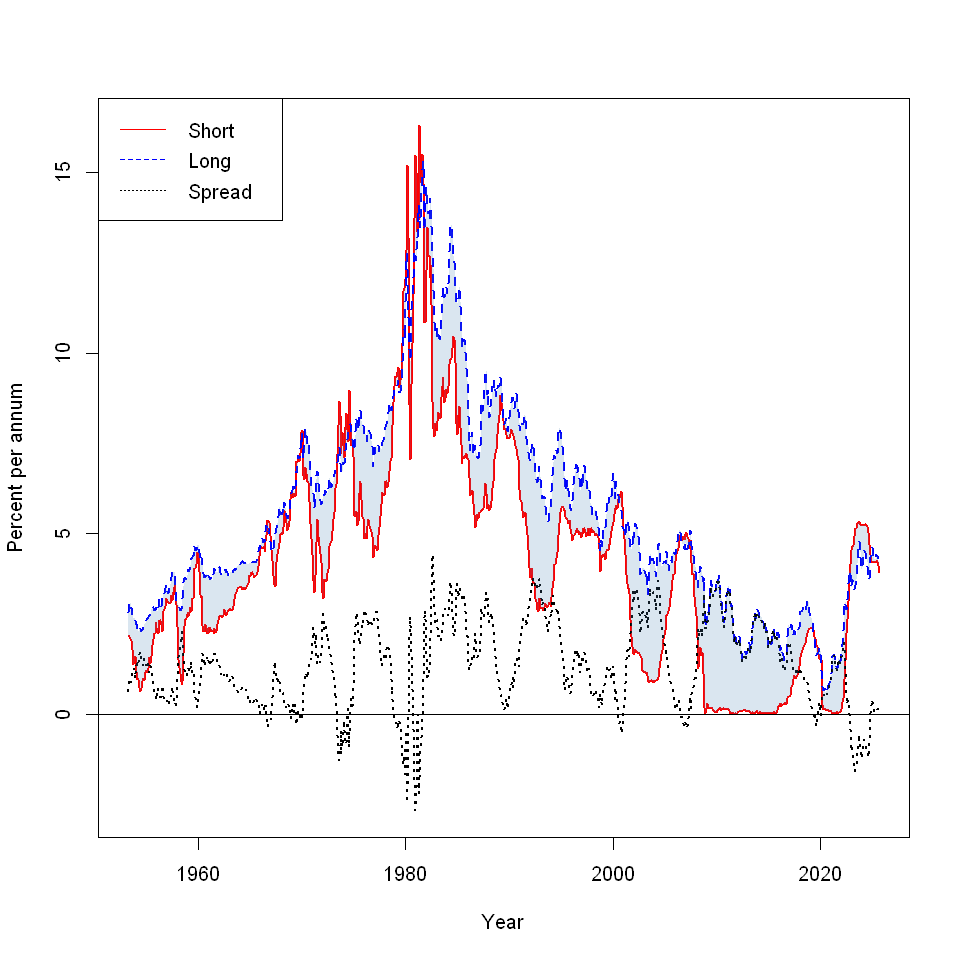

In [41]:
# Load libraries for plotting and color adjustment
library(graphics)
library(grDevices)

# Align and combine short-term, long-term, and spread series (keep overlapping dates only)
temp = ts.intersect(stir, ltir, spread)

# Set plot dimensions for notebook display
options(repr.plot.width=8, repr.plot.height=8)

# Plot the three series with different line styles, colors, and labels
ts.plot(temp, lty = c(1,2,3), lwd = c(2,2,2), col = c("red", "blue", "black"),
        xlab = "Year", ylab = "Percent per annum")

# Add a legend to identify the three series
legend("topleft", legend = c("Short", "Long", "Spread"),
       col = c("red", "blue", "black"), lty = c(1,2,3))

# Draw a horizontal line at zero
abline(0, 0)

# Add shaded area between short- and long-term interest rates
polygon(c(time(temp[,1]), rev(time(temp[,2]))),
        c(temp[,1], rev(temp[,2])),
        col = adjustcolor("steelblue", alpha = 0.2),
        border = NA)


<div style="background-color:lightyellow; padding:15px; border-radius:5px;">
  <h3>Interpretation</h3>
  <p>
    The plot shows the evolution of short-term, long-term, and spread (long minus short) interest rates in the US over time.
  </p>
  <p>
    The <strong>short-term rate</strong> (red line) and the <strong>long-term rate</strong> (blue dashed line) move closely together throughout the sample. 
    Both series rise and fall around the same periods — for instance, sharp increases during the 1970s and gradual declines afterward — indicating that they share a 
    <strong>common long-run trend</strong>.
  </p>
  <p>
    The <strong>spread</strong> (black dotted line), representing the difference between long- and short-term interest rates, fluctuates around a stable mean 
    and does not show a persistent trend over time. This behavior suggests that the spread is <strong>stationary</strong>.
  </p>
  <p>
    Overall, the plot suggests that long-term and short-term interest rates <strong>seem to be cointegrated</strong>: 
    both exhibit similar long-run movements, consistent with a shared stochastic trend. The spread, as a linear combination of the two rates, 
    <strong>appears stationary</strong>, which is the hallmark of cointegration.
  </p>
  <p>
    In economic terms, this indicates that while short- and long-term interest rates can deviate temporarily, they tend to move together in the long run, 
    maintaining a stable relationship — a result often explained by the <strong>expectations hypothesis of the term structure of interest rates</strong>.
  </p>
</div>

<div style="background-color:#e6f2ff; padding:15px; border-radius:5px;">
  <h2>Testing for Cointegration</h2>
  <p>
    <strong>Step 1:</strong> Determine whether \( X_t \) and \( Y_t \) are integrated of the same order.
  </p>
  <p>
    <strong>Step 2:</strong> Test whether there exists a cointegrating relationship between \( X_t \) and \( Y_t \).
  </p>
</div>


<div style="background-color:#e6f2ff; padding:15px; border-radius:5px;">
  <h2>Testing for Cointegration</h2>
     <p>
    <strong>Step 1:</strong> Determine whether \( X_t \) and \( Y_t \) are integrated of the same order.
    </p>
</div>

In [42]:
library(urca)
summary(ur.df(stir, type='trend', lags=8, selectlags="AIC"))


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression trend 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + tt + z.diff.lag)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.3607 -0.0658 -0.0173  0.0839  2.3360 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.813e-02  2.105e-02   1.336   0.1818    
z.lag.1     -7.472e-03  3.171e-03  -2.357   0.0186 *  
tt           8.702e-08  3.067e-05   0.003   0.9977    
z.diff.lag1  4.325e-01  3.007e-02  14.385  < 2e-16 ***
z.diff.lag2 -1.812e-01  3.278e-02  -5.526 4.09e-08 ***
z.diff.lag3  4.079e-02  3.262e-02   1.251   0.2114    
z.diff.lag4 -5.870e-02  3.239e-02  -1.813   0.0702 .  
z.diff.lag5  1.420e-01  3.237e-02   4.386 1.27e-05 ***
z.diff.lag6 -2.033e-01  3.264e-02  -6.229 6.73e-10 ***
z.diff.lag7 -4.283e-02  3.271e-02  -1.309   0.1907    
z.diff.lag8  1.447e-01  3.007e-02   4.813 1.70e-06 **

<div style="background-color:lightyellow; padding:15px; border-radius:5px;">
  <h3>ADF Test Interpretation</h3>

  <p><b>Test statistics:</b><br>
    <span style="font-family: 'Times New Roman', serif;">τ<sub>3</sub> = −2.3567</span>, 
    <span style="font-family: 'Times New Roman', serif;">φ<sub>2</sub> = 1.9178</span>, 
    <span style="font-family: 'Times New Roman', serif;">φ<sub>3</sub> = 2.8403</span>
  </p>

  <p><b>Critical values:</b></p>

  <table style="border-collapse: collapse; margin-left: 20px;">
    <tr>
      <th style="border: 1px solid #999; padding: 4px 10px; text-align: center;">Significance</th>
      <th style="border: 1px solid #999; padding: 4px 10px; text-align: center;">1%</th>
      <th style="border: 1px solid #999; padding: 4px 10px; text-align: center;">5%</th>
      <th style="border: 1px solid #999; padding: 4px 10px; text-align: center;">10%</th>
    </tr>
    <tr>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">τ<sub>3</sub></td>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">−3.96</td>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">−3.41</td>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">−3.12</td>
    </tr>
    <tr>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">φ<sub>2</sub></td>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">6.09</td>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">4.68</td>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">4.03</td>
    </tr>
    <tr>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">φ<sub>3</sub></td>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">8.27</td>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">6.25</td>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">5.34</td>
    </tr>
  </table>

  <p><b>Interpretation:</b></p>
  <ul>
    <li>We <b>cannot reject</b> that the <b>constant and deterministic trend are jointly zero</b> because <span style="font-family: 'Times New Roman', serif;">φ<sub>2</sub> = 1.9178 &lt; 4.03</span> (even below the 10% critical value).</li>
    <li>We also <b>cannot reject</b> that the <b>deterministic trend is zero</b> because <span style="font-family: 'Times New Roman', serif;">φ<sub>3</sub> = 2.8403 &lt; 5.34</span> (even below the 10% critical value).</li>
    <li><b>Action:</b> Rerun the ADF test with <b>specification = "none"</b> (no constant, no deterministic trend).</li>
  </ul>
</div>


In [43]:
library(urca)
summary(ur.df(stir, type='none', lags=8, selectlags="AIC"))


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression none 


Call:
lm(formula = z.diff ~ z.lag.1 - 1 + z.diff.lag)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.3842 -0.0541  0.0053  0.0975  2.3084 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
z.lag.1     -0.002882   0.002086  -1.382   0.1673    
z.diff.lag1  0.431066   0.030077  14.332  < 2e-16 ***
z.diff.lag2 -0.183965   0.032774  -5.613 2.52e-08 ***
z.diff.lag3  0.039179   0.032636   1.201   0.2302    
z.diff.lag4 -0.060807   0.032393  -1.877   0.0608 .  
z.diff.lag5  0.140266   0.032387   4.331 1.62e-05 ***
z.diff.lag6 -0.205633   0.032648  -6.299 4.36e-10 ***
z.diff.lag7 -0.043998   0.032733  -1.344   0.1792    
z.diff.lag8  0.142620   0.030075   4.742 2.40e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.316 on 1083 degrees of freedo

<div style="background-color:lightyellow; padding:15px; border-radius:5px;">
  <h3>ADF Test Interpretation (No Constant, No Trend)</h3>

  <p><b>Test statistic:</b><br>
    <span style="font-family: 'Times New Roman', serif;">τ<sub>1</sub> = −1.3819</span>
  </p>

  <p><b>Critical values:</b></p>

  <table style="border-collapse: collapse; margin-left: 20px;">
    <tr>
      <th style="border: 1px solid #999; padding: 4px 10px; text-align: center;">Significance</th>
      <th style="border: 1px solid #999; padding: 4px 10px; text-align: center;">1%</th>
      <th style="border: 1px solid #999; padding: 4px 10px; text-align: center;">5%</th>
      <th style="border: 1px solid #999; padding: 4px 10px; text-align: center;">10%</th>
    </tr>
    <tr>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">τ<sub>1</sub></td>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">−2.58</td>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">−1.95</td>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">−1.62</td>
    </tr>
  </table>

  <p><b>Interpretation:</b></p>
  <ul>
    <li>The test statistic <span style="font-family: 'Times New Roman', serif;">τ<sub>1</sub> = −1.3819</span> is greater than all critical values (−2.58, −1.95, −1.62).</li>
    <li>Therefore, we <b>cannot reject the null hypothesis</b> of a unit root at any conventional significance level.</li>
  </ul>
</div>


In [44]:
# Define the monthly change in short-term interest rates
dstir = diff(stir)

In [45]:
library(urca)
summary(ur.df(dstir, type='none', lags=8, selectlags="AIC"))


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression none 


Call:
lm(formula = z.diff ~ z.lag.1 - 1 + z.diff.lag)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.5062 -0.0590  0.0007  0.0867  2.1896 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
z.lag.1     -0.67007    0.07015  -9.552  < 2e-16 ***
z.diff.lag1  0.08408    0.06676   1.259 0.208132    
z.diff.lag2 -0.09700    0.06129  -1.583 0.113813    
z.diff.lag3 -0.03611    0.05566  -0.649 0.516585    
z.diff.lag4 -0.11401    0.05217  -2.185 0.029068 *  
z.diff.lag5  0.03174    0.04653   0.682 0.495305    
z.diff.lag6 -0.17989    0.04129  -4.356 1.45e-05 ***
z.diff.lag7 -0.20412    0.03451  -5.915 4.44e-09 ***
z.diff.lag8 -0.11108    0.03020  -3.678 0.000247 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.3145 on 1082 degrees of freedom
Multipl

<div style="background-color:lightyellow; padding:15px; border-radius:5px;">
  <h3>ADF Test Interpretation (Second Unit Root, No Constant, No Trend)</h3>

  <p><b>Test statistic:</b><br>
    <span style="font-family: 'Times New Roman', serif;">τ<sub>1</sub> = −9.5521</span>
  </p>

  <p><b>Critical values:</b></p>

  <table style="border-collapse: collapse; margin-left: 20px;">
    <tr>
      <th style="border: 1px solid #999; padding: 4px 10px; text-align: center;">Significance</th>
      <th style="border: 1px solid #999; padding: 4px 10px; text-align: center;">1%</th>
      <th style="border: 1px solid #999; padding: 4px 10px; text-align: center;">5%</th>
      <th style="border: 1px solid #999; padding: 4px 10px; text-align: center;">10%</th>
    </tr>
    <tr>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">τ<sub>1</sub></td>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">−2.58</td>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">−1.95</td>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">−1.62</td>
    </tr>
  </table>

  <p><b>Interpretation:</b></p>
  <ul>
    <li>The test statistic <span style="font-family: 'Times New Roman', serif;">τ<sub>1</sub> = −9.5521</span> is far below all critical values.</li>
    <li>We therefore <b>reject the null hypothesis</b> of a unit root at the 1% level.</li>
    <li>As this is a test for a <b>second unit root</b> (i.e., testing the first difference), the result indicates the series is <b>stationary after first differencing</b>.</li>
    <li>Conclusion: the process is <b>I(1), not I(2)</b>.</li>
  </ul>
</div>


In [46]:
library(urca)
summary(ur.df(ltir, type='trend', lags=8, selectlags="AIC"))


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression trend 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + tt + z.diff.lag)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.4269 -0.1291 -0.0103  0.1276  1.4515 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  5.820e-02  2.720e-02   2.139  0.03270 *  
z.lag.1     -6.342e-03  3.033e-03  -2.091  0.03685 *  
tt          -4.918e-05  3.492e-05  -1.409  0.15935    
z.diff.lag1  4.001e-01  3.411e-02  11.731  < 2e-16 ***
z.diff.lag2 -2.470e-01  3.671e-02  -6.727 3.17e-11 ***
z.diff.lag3  1.087e-01  3.760e-02   2.890  0.00395 ** 
z.diff.lag4 -7.921e-02  3.764e-02  -2.104  0.03564 *  
z.diff.lag5  1.006e-01  3.764e-02   2.673  0.00767 ** 
z.diff.lag6 -5.939e-02  3.761e-02  -1.579  0.11468    
z.diff.lag7 -5.341e-02  3.667e-02  -1.457  0.14558    
z.diff.lag8  8.284e-02  3.411e-02   2.428  0.01538 * 

<div style="background-color:lightyellow; padding:15px; border-radius:5px;">
  <h3>ADF Test Interpretation</h3>

  <p><b>Test statistics:</b><br>
    <span style="font-family: 'Times New Roman', serif;">τ<sub>3</sub> = −2.0907</span>, 
    <span style="font-family: 'Times New Roman', serif;">φ<sub>2</sub> = 1.6956</span>, 
    <span style="font-family: 'Times New Roman', serif;">φ<sub>3</sub> = 2.5301</span>
  </p>

  <p><b>Critical values:</b></p>

  <table style="border-collapse: collapse; margin-left: 20px;">
    <tr>
      <th style="border: 1px solid #999; padding: 4px 10px; text-align: center;">Significance</th>
      <th style="border: 1px solid #999; padding: 4px 10px; text-align: center;">1%</th>
      <th style="border: 1px solid #999; padding: 4px 10px; text-align: center;">5%</th>
      <th style="border: 1px solid #999; padding: 4px 10px; text-align: center;">10%</th>
    </tr>
    <tr>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">τ<sub>3</sub></td>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">−3.96</td>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">−3.41</td>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">−3.12</td>
    </tr>
    <tr>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">φ<sub>2</sub></td>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">6.09</td>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">4.68</td>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">4.03</td>
    </tr>
    <tr>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">φ<sub>3</sub></td>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">8.27</td>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">6.25</td>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">5.34</td>
    </tr>
  </table>

  <p><b>Interpretation:</b></p>
  <ul>
    <li>We <b>cannot reject</b> that both the <b>constant and deterministic trend are zero</b> since <span style="font-family: 'Times New Roman', serif;">φ<sub>2</sub> = 1.6956 &lt; 4.03</span> (even below the 10% critical value).</li>
    <li>We also <b>cannot reject</b> that the <b>deterministic trend is zero</b> because <span style="font-family: 'Times New Roman', serif;">φ<sub>3</sub> = 2.5301 &lt; 5.34</span> (even below the 10% critical value).</li>
    <li><b>Action:</b> Rerun the ADF test with <b>specification = "none"</b> (no constant, no deterministic trend).</li>
  </ul>
</div>


In [47]:
library(urca)
summary(ur.df(ltir, type='none', lags=8, selectlags="AIC"))


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression none 


Call:
lm(formula = z.diff ~ z.lag.1 - 1 + z.diff.lag)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.46489 -0.12567  0.00637  0.13717  1.43644 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
z.lag.1     -0.0008692  0.0013264  -0.655  0.51244    
z.diff.lag1  0.3998241  0.0341435  11.710  < 2e-16 ***
z.diff.lag2 -0.2492329  0.0367386  -6.784 2.19e-11 ***
z.diff.lag3  0.1076882  0.0376433   2.861  0.00433 ** 
z.diff.lag4 -0.0810105  0.0376792  -2.150  0.03184 *  
z.diff.lag5  0.0994894  0.0376801   2.640  0.00843 ** 
z.diff.lag6 -0.0614086  0.0376434  -1.631  0.10319    
z.diff.lag7 -0.0545691  0.0367142  -1.486  0.13756    
z.diff.lag8  0.0813124  0.0341394   2.382  0.01745 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.2431 on 8

<div style="background-color:lightyellow; padding:15px; border-radius:5px;">
  <h3>ADF Test Interpretation (No Constant, No Trend)</h3>

  <p><b>Test statistic:</b><br>
    <span style="font-family: 'Times New Roman', serif;">τ<sub>1</sub> = −0.6553</span>
  </p>

  <p><b>Critical values:</b></p>

  <table style="border-collapse: collapse; margin-left: 20px;">
    <tr>
      <th style="border: 1px solid #999; padding: 4px 10px; text-align: center;">Significance</th>
      <th style="border: 1px solid #999; padding: 4px 10px; text-align: center;">1%</th>
      <th style="border: 1px solid #999; padding: 4px 10px; text-align: center;">5%</th>
      <th style="border: 1px solid #999; padding: 4px 10px; text-align: center;">10%</th>
    </tr>
    <tr>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">τ<sub>1</sub></td>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">−2.58</td>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">−1.95</td>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">−1.62</td>
    </tr>
  </table>

  <p><b>Interpretation:</b></p>
  <ul>
    <li>The test statistic <span style="font-family: 'Times New Roman', serif;">τ<sub>1</sub> = −0.6553</span> is greater than all critical values (−2.58, −1.95, −1.62).</li>
    <li>Therefore, we <b>cannot reject the null hypothesis</b> of a unit root at any conventional significance level.</li>
  </ul>
</div>



In [48]:
# Define the monthly change in long-term interest rates
dltir = diff(ltir)

In [49]:
library(urca)
summary(ur.df(dltir, type='none', lags=8, selectlags="AIC"))


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression none 


Call:
lm(formula = z.diff ~ z.lag.1 - 1 + z.diff.lag)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.47673 -0.13064  0.00286  0.13189  1.42809 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
z.lag.1     -0.76208    0.07713  -9.880   <2e-16 ***
z.diff.lag1  0.16130    0.07198   2.241   0.0253 *  
z.diff.lag2 -0.08833    0.06695  -1.319   0.1874    
z.diff.lag3  0.01858    0.06225   0.299   0.7654    
z.diff.lag4 -0.06302    0.05547  -1.136   0.2562    
z.diff.lag5  0.03615    0.04936   0.732   0.4641    
z.diff.lag6 -0.02610    0.03987  -0.655   0.5129    
z.diff.lag7 -0.08095    0.03414  -2.371   0.0180 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.2432 on 852 degrees of freedom
Multiple R-squared:  0.3929,	Adjusted R-squared:  0

<div style="background-color:lightyellow; padding:15px; border-radius:5px;">
  <h3>ADF Test Interpretation (First Difference, Testing for Second Unit Root)</h3>

  <p><b>Test statistic:</b><br>
    <span style="font-family: 'Times New Roman', serif;">τ<sub>1</sub> = −9.8803</span>
  </p>

  <p><b>Critical values:</b></p>

  <table style="border-collapse: collapse; margin-left: 20px;">
    <tr>
      <th style="border: 1px solid #999; padding: 4px 10px; text-align: center;">Significance</th>
      <th style="border: 1px solid #999; padding: 4px 10px; text-align: center;">1%</th>
      <th style="border: 1px solid #999; padding: 4px 10px; text-align: center;">5%</th>
      <th style="border: 1px solid #999; padding: 4px 10px; text-align: center;">10%</th>
    </tr>
    <tr>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">τ<sub>1</sub></td>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">−2.58</td>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">−1.95</td>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">−1.62</td>
    </tr>
  </table>

  <p><b>Interpretation:</b></p>
  <ul>
    <li>The test statistic <span style="font-family: 'Times New Roman', serif;">τ<sub>1</sub> = −9.8803</span> is much lower (more negative) than all critical values.</li>
    <li>We therefore <b>reject the null hypothesis</b> of a unit root at the 1% significance level.</li>
    <li>Because this test is applied to the <b>first difference</b> of the series, the result indicates that the differenced series is <b>stationary</b>.</li>
    <li><b>Conclusion:</b> The series is <b>I(1)</b> — it becomes stationary after first differencing, and there is <b>no evidence of a second unit root</b>.</li>
  </ul>
</div>


<div style="background-color:lightyellow; padding:15px; border-radius:5px;">
<b>We have found that both</b> \(X_t\) <b>and</b> \(Y_t\) <b>are integrated of order 1</b>:  
<br><br>
\[
X_t \sim I(1) \quad \text{and} \quad Y_t \sim I(1)
\]
<br>
<b>So, both series are integrated of the same order and the first out of the two steps needed for a conintegration relationship to exist is satisfied!</b>
</div>


<div style="background-color:#e6f2ff; padding:15px; border-radius:5px;">
  <h2>Income and Consumption per Capita</h2>

  <p><strong>\( Z_t \):</strong> Income per capita for the US  
  <br>
  Real Disposable Personal Income: Per Capita  
  (<a href="https://fred.stlouisfed.org/series/A229RX0" target="_blank">
  A229RX0 – FRED Database
  </a>)
  </p>

  <ul>
    <li><strong>Frequency:</strong> Quarterly, Average</li>
    <li><strong>Units:</strong> Chained 2017 Dollars</li>
    <li><strong>Seasonal Adjustment:</strong> Seasonally adjusted annual rate</li>
    <li><strong>Data Availability:</strong> 1959-01-01 through 2025-04-01</li>
  </ul>
  <p><em>Source:</em> U.S. Bureau of Economic Analysis</p>

  <p><strong>\( W_t \):</strong> Consumption expenditures per capita for the US  
  <br>
  Real Personal Consumption Expenditures: Per Capita  
  (<a href="https://fred.stlouisfed.org/series/A794RX0Q048SBEA" target="_blank">
  A794RX0Q048SBEA – FRED Database
  </a>)
  </p>

  <ul>
    <li><strong>Frequency:</strong> Quarterly</li>
    <li><strong>Units:</strong> Chained 2017 Dollars</li>
    <li><strong>Seasonal Adjustment:</strong> Seasonally adjusted annual rate</li>
    <li><strong>Data Availability:</strong> 1947-01-01 through 2025-04-01</li>
  </ul>
  <p><em>Source:</em> U.S. Bureau of Economic Analysis</p>

</div>

    

In [50]:
imp3 = read.csv("A229RX0.csv")            # rate data from CSV into a data frame
imp4 = read.csv("A794RX0Q048SBEA.csv")    # rate data from CSV into a data frame

head(imp3)  # quickly preview the first 6 rows of A229RX0.csv
head(imp4)  # quickly preview the first 6 rows of A794RX0Q048SBEA.csv

tail(imp3)  # see the last 6 rows
tail(imp4)  # see the last 6 rows

,observation_date,A229RX0
,<chr>,<int>
1,1959-01-01,13221
2,1959-04-01,13382
3,1959-07-01,13308
4,1959-10-01,13343
5,1960-01-01,13418
6,1960-04-01,13424


,observation_date,A794RX0Q048SBEA
,<chr>,<int>
1,1947-01-01,9441
2,1947-04-01,9555
3,1947-07-01,9542
4,1947-10-01,9501
5,1948-01-01,9510
6,1948-04-01,9582


,observation_date,A229RX0
,<chr>,<int>
261,2024-01-01,51888
262,2024-04-01,52072
263,2024-07-01,52124
264,2024-10-01,52301
265,2025-01-01,52528
266,2025-04-01,52867


,observation_date,A794RX0Q048SBEA
,<chr>,<int>
309,2024-01-01,46761
310,2024-04-01,47097
311,2024-07-01,47458
312,2024-10-01,47839
313,2025-01-01,47852
314,2025-04-01,48082


In [51]:
# Create a quarterly time series of income per capita
inc = ts(as.numeric(imp3[,2]), frequency = 4, start = c(1959, 1))  

# Create a quarterly time series of consumption per capita
con = ts(as.numeric(imp4[,2]), frequency = 4, start = c(1947, 4))  

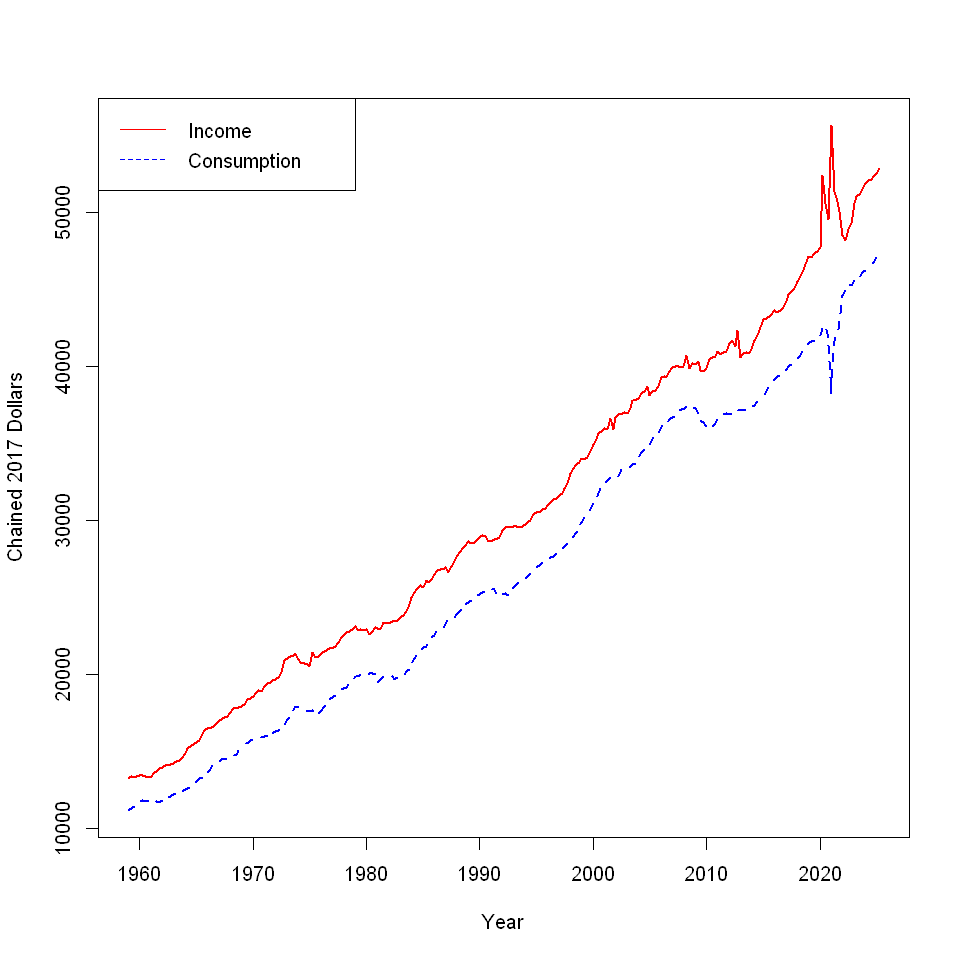

In [52]:
# Load libraries for plotting and color adjustment
library(graphics)
library(grDevices)

# Align and combine short-term, long-term, and spread series (keep overlapping dates only)
temp = ts.intersect(inc, con)

# Set plot dimensions for notebook display
options(repr.plot.width=8, repr.plot.height=8)

# Plot the three series with different line styles, colors, and labels
ts.plot(temp, lty = c(1,2), lwd = c(2,2), col = c("red", "blue"),
        xlab = "Year", ylab="Chained 2017 Dollars")

# Add a legend to identify the three series
legend("topleft", legend = c("Income", "Consumption"),
       col = c("red", "blue"), lty = c(1,2))


<div style="background-color:#e6f2ff; padding:15px; border-radius:5px;">

<h2> Exercise 1</h2>
    
Determine whether income and cosumption per capita are integrated of the same order.
</div>

<div style="background-color:#e6f2ff; padding:15px; border-radius:5px;">

<h2>Solution to Exercise 1</h2>

</div>

In [53]:
library(urca)
summary(ur.df(inc, type='trend', lags=8, selectlags="AIC"))


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression trend 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + tt + z.diff.lag)

Residuals:
    Min      1Q  Median      3Q     Max 
-2789.6  -175.9    -3.2   160.4  4690.6 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 523.96123  323.54436   1.619   0.1066    
z.lag.1      -0.02967    0.02935  -1.011   0.3131    
tt            5.02119    4.24823   1.182   0.2384    
z.diff.lag1  -0.40245    0.06706  -6.001 6.95e-09 ***
z.diff.lag2  -0.11678    0.06788  -1.720   0.0866 .  
z.diff.lag3   0.34014    0.06578   5.171 4.82e-07 ***
z.diff.lag4  -0.06395    0.06897  -0.927   0.3547    
z.diff.lag5  -0.22898    0.06670  -3.433   0.0007 ***
z.diff.lag6  -0.29977    0.06733  -4.452 1.29e-05 ***
z.diff.lag7  -0.13702    0.06366  -2.152   0.0323 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' '

<div style="background-color:lightyellow; padding:15px; border-radius:5px;">
  <h3>ADF Test Interpretation</h3>

  <p><b>Test statistics:</b><br>
    <span style="font-family: 'Times New Roman', serif;">τ<sub>3</sub> = −1.0109</span>, 
    <span style="font-family: 'Times New Roman', serif;">φ<sub>2</sub> = 15.3267</span>, 
    <span style="font-family: 'Times New Roman', serif;">φ<sub>3</sub> = 1.8973</span>
  </p>

  <p><b>Critical values:</b></p>

  <table style="border-collapse: collapse; margin-left: 20px;">
    <tr>
      <th style="border: 1px solid #999; padding: 4px 10px; text-align: center;">Significance</th>
      <th style="border: 1px solid #999; padding: 4px 10px; text-align: center;">1%</th>
      <th style="border: 1px solid #999; padding: 4px 10px; text-align: center;">5%</th>
      <th style="border: 1px solid #999; padding: 4px 10px; text-align: center;">10%</th>
    </tr>
    <tr>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">τ<sub>3</sub></td>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">−3.98</td>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">−3.42</td>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">−3.13</td>
    </tr>
    <tr>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">φ<sub>2</sub></td>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">6.15</td>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">4.71</td>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">4.05</td>
    </tr>
    <tr>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">φ<sub>3</sub></td>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">8.34</td>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">6.30</td>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">5.36</td>
    </tr>
  </table>

  <p><b>Interpretation:</b></p>
  <ul>
    <li>The <b>φ<sub>2</sub></b> statistic (15.3267) is <b>larger than</b> the 1% critical value (6.15), so we <b>reject</b> that the <b>constant and trend are jointly zero</b> — a deterministic trend should be included.</li>
    <li>The <b>φ<sub>3</sub></b> statistic (1.8973) is <b>smaller than</b> even the 10% critical value (5.36), so we <b>cannot reject</b> that the <b>deterministic trend is zero</b>.</li>
    <li><b>Action:</b> Keep the <b>constant term</b> but remove the <b>trend</b>; rerun the ADF test with <b>specification = "drift"</b> (constant only).</li>
  </ul>
</div>



In [54]:
library(urca)
summary(ur.df(inc, type='drift', lags=8, selectlags="AIC"))


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression drift 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + z.diff.lag)

Residuals:
    Min      1Q  Median      3Q     Max 
-2886.1  -161.5    -3.0   154.0  4673.9 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) 160.316088 100.192979   1.600 0.110855    
z.lag.1       0.004824   0.003118   1.547 0.123097    
z.diff.lag1  -0.429304   0.063147  -6.799 7.83e-11 ***
z.diff.lag2  -0.137502   0.065629  -2.095 0.037172 *  
z.diff.lag3   0.322887   0.064194   5.030 9.42e-07 ***
z.diff.lag4  -0.082496   0.067217  -1.227 0.220870    
z.diff.lag5  -0.250406   0.064241  -3.898 0.000125 ***
z.diff.lag6  -0.317878   0.065615  -4.845 2.24e-06 ***
z.diff.lag7  -0.148345   0.062981  -2.355 0.019282 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 527.7 on 248 degrees

<div style="background-color:lightyellow; padding:15px; border-radius:5px;">
  <h3>ADF Test Interpretation (No Trend)</h3>

  <p><b>Test statistics:</b><br>
    <span style="font-family: 'Times New Roman', serif;">τ<sub>2</sub> = 1.5472</span>, 
    <span style="font-family: 'Times New Roman', serif;">φ<sub>1</sub> = 22.2559</span>
  </p>

  <p><b>Critical values:</b></p>

  <table style="border-collapse: collapse; margin-left: 20px;">
    <tr>
      <th style="border: 1px solid #999; padding: 4px 10px; text-align: center;">Significance</th>
      <th style="border: 1px solid #999; padding: 4px 10px; text-align: center;">1%</th>
      <th style="border: 1px solid #999; padding: 4px 10px; text-align: center;">5%</th>
      <th style="border: 1px solid #999; padding: 4px 10px; text-align: center;">10%</th>
    </tr>
    <tr>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">τ<sub>2</sub></td>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">−3.44</td>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">−2.87</td>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">−2.57</td>
    </tr>
    <tr>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">φ<sub>1</sub></td>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">6.47</td>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">4.61</td>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">3.79</td>
    </tr>
  </table>

  <p><b>Interpretation:</b></p>
  <ul>
    <li>The <b>φ<sub>1</sub></b> statistic (22.2559) is <b>well above</b> the 1% critical value (6.47), meaning we <b>reject</b> the null that the <b>constant is zero</b>.</li>
       <li>The <b>τ<sub>2</sub></b> statistic (1.5472) is <b>greater than</b> all critical values.
    <li>Therefore, we <b>cannot reject the null hypothesis</b> of a unit root at any conventional significance level.</li>
  </ul>
</div>


In [55]:
dinc = diff(log(inc))

In [56]:
library(urca)
summary(ur.df(dinc, type='drift', lags=8, selectlags="AIC"))


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression drift 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + z.diff.lag)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.055537 -0.004836 -0.000477  0.005516  0.089538 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.007354   0.001208   6.086 4.34e-09 ***
z.lag.1     -1.384728   0.171942  -8.053 3.33e-14 ***
z.diff.lag1  0.115560   0.154588   0.748 0.455446    
z.diff.lag2  0.109426   0.138920   0.788 0.431625    
z.diff.lag3  0.422299   0.125087   3.376 0.000853 ***
z.diff.lag4  0.313051   0.099560   3.144 0.001867 ** 
z.diff.lag5  0.139308   0.062547   2.227 0.026824 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.01267 on 249 degrees of freedom
Multiple R-squared:  0.6852,	Adjusted R-squared:  0.6776 
F-statistic: 90.34 on 6 an

 <div style="background-color:lightyellow; padding:15px; border-radius:5px;">
  <h3>ADF Test Interpretation (First Difference, Testing for Second Unit Root)</h3>

  <p><b>Test statistics:</b><br>
    <span style="font-family: 'Times New Roman', serif;">τ<sub>2</sub> = -8.0535</span>, 
    <span style="font-family: 'Times New Roman', serif;">φ<sub>1</sub> = 32.4292</span>
  </p>

  <p><b>Critical values:</b></p>

  <table style="border-collapse: collapse; margin-left: 20px;">
    <tr>
      <th style="border: 1px solid #999; padding: 4px 10px; text-align: center;">Significance</th>
      <th style="border: 1px solid #999; padding: 4px 10px; text-align: center;">1%</th>
      <th style="border: 1px solid #999; padding: 4px 10px; text-align: center;">5%</th>
      <th style="border: 1px solid #999; padding: 4px 10px; text-align: center;">10%</th>
    </tr>
    <tr>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">τ<sub>2</sub></td>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">−3.44</td>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">−2.87</td>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">−2.57</td>
    </tr>
    <tr>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">φ<sub>1</sub></td>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">6.47</td>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">4.61</td>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">3.79</td>
    </tr>
  </table>

  <p><b>Interpretation:</b></p>
  <ul>
    <li>The <b>τ<sub>2</sub></b> statistic (-8.0535) is <b>much smaller</b> than all critical values, so we <b>strongly reject</b> the null hypothesis of a unit root at the 1% level. The differenced series is <b>stationary</b>.</li>
    <li>The <b>φ<sub>1</sub></b> statistic (32.4292) is far above the 1% critical value (6.47), confirming that the <b>constant term is significant</b>.</li>
    <li><b>Conclusion:</b> Since the first-differenced series is stationary, the original series is <b>integrated of order one</b>, I(1). No second unit root is present.</li>
  </ul>
</div>


In [57]:
library(urca)
summary(ur.df(con, type='trend', lags=8, selectlags="AIC"))


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression trend 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + tt + z.diff.lag)

Residuals:
    Min      1Q  Median      3Q     Max 
-3946.9   -85.9     5.1   101.2  2667.1 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)  
(Intercept) 147.27908   71.12551   2.071   0.0392 *
z.lag.1      -0.01913    0.01220  -1.568   0.1180  
tt            2.93749    1.54431   1.902   0.0581 .
z.diff.lag   -0.11849    0.05726  -2.069   0.0394 *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 335.4 on 301 degrees of freedom
Multiple R-squared:  0.03945,	Adjusted R-squared:  0.02988 
F-statistic: 4.121 on 3 and 301 DF,  p-value: 0.006933


Value of test-statistic is: -1.5675 18.4772 4.2619 

Critical values for test statistics: 
      1pct  5pct 10pct
tau3 -3.98 -3.42 -3.13
phi2  6.15  4.71  4

<div style="background-color:lightyellow; padding:15px; border-radius:5px;">
  <h3>ADF Test Interpretation</h3>

  <p><b>Test statistics:</b><br>
    <span style="font-family: 'Times New Roman', serif;">τ<sub>3</sub> = −1.5675</span>, 
    <span style="font-family: 'Times New Roman', serif;">φ<sub>2</sub> = 18.4772</span>, 
    <span style="font-family: 'Times New Roman', serif;">φ<sub>3</sub> = 4.2619</span>
  </p>

  <p><b>Critical values:</b></p>

  <table style="border-collapse: collapse; margin-left: 20px;">
    <tr>
      <th style="border: 1px solid #999; padding: 4px 10px; text-align: center;">Significance</th>
      <th style="border: 1px solid #999; padding: 4px 10px; text-align: center;">1%</th>
      <th style="border: 1px solid #999; padding: 4px 10px; text-align: center;">5%</th>
      <th style="border: 1px solid #999; padding: 4px 10px; text-align: center;">10%</th>
    </tr>
    <tr>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">τ<sub>3</sub></td>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">−3.98</td>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">−3.42</td>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">−3.13</td>
    </tr>
    <tr>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">φ<sub>2</sub></td>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">6.15</td>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">4.71</td>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">4.05</td>
    </tr>
    <tr>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">φ<sub>3</sub></td>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">8.34</td>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">6.30</td>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">5.36</td>
    </tr>
  </table>

  <p><b>Interpretation:</b></p>
  <ul>
    <li>The <b>φ<sub>2</sub></b> statistic (18.4772) is <b>well above</b> the 1% critical value (6.15), meaning the <b>constant and trend are jointly significant</b>.</li>
    <li>The <b>φ<sub>3</sub></b> statistic (4.2619) is <b>not in the rejection region</b>.</li>
    <li><b>Action:</b> Remove the <b>trend</b> in the specification and proceed to re-test.</li>
  </ul>
</div>


In [58]:
library(urca)
summary(ur.df(con, type='drift', lags=8, selectlags="AIC"))


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression drift 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + z.diff.lag)

Residuals:
    Min      1Q  Median      3Q     Max 
-3954.9   -88.4     7.8    96.5  2717.8 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)  
(Intercept) 46.036119  47.383043   0.972   0.3320  
z.lag.1      0.003848   0.001745   2.205   0.0282 *
z.diff.lag  -0.128216   0.057280  -2.238   0.0259 *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 336.8 on 302 degrees of freedom
Multiple R-squared:  0.02791,	Adjusted R-squared:  0.02147 
F-statistic: 4.335 on 2 and 302 DF,  p-value: 0.01393


Value of test-statistic is: 2.2053 25.6841 

Critical values for test statistics: 
      1pct  5pct 10pct
tau2 -3.44 -2.87 -2.57
phi1  6.47  4.61  3.79


<div style="background-color:lightyellow; padding:15px; border-radius:5px;">
  <h3>ADF Test Interpretation (No Trend)</h3>

  <p><b>Test statistics:</b><br>
    <span style="font-family: 'Times New Roman', serif;">τ<sub>2</sub> = 2.2053</span>, 
    <span style="font-family: 'Times New Roman', serif;">φ<sub>1</sub> = 25.6841</span>
  </p>

  <p><b>Critical values:</b></p>

  <table style="border-collapse: collapse; margin-left: 20px;">
    <tr>
      <th style="border: 1px solid #999; padding: 4px 10px; text-align: center;">Significance</th>
      <th style="border: 1px solid #999; padding: 4px 10px; text-align: center;">1%</th>
      <th style="border: 1px solid #999; padding: 4px 10px; text-align: center;">5%</th>
      <th style="border: 1px solid #999; padding: 4px 10px; text-align: center;">10%</th>
    </tr>
    <tr>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">τ<sub>2</sub></td>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">−3.44</td>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">−2.87</td>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">−2.57</td>
    </tr>
    <tr>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">φ<sub>1</sub></td>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">6.47</td>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">4.61</td>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">3.79</td>
    </tr>
  </table>

  <p><b>Interpretation:</b></p>
  <ul>
    <li>The <b>τ<sub>2</sub></b> statistic (2.2053) is <b>greater than</b> all critical values, so we <b>cannot reject</b> the null hypothesis of a unit root. The series is <b>non-stationary</b>.</li>
    <li>The <b>φ<sub>1</sub></b> statistic (25.6841) is <b>well above</b> the 1% critical value (6.47), confirming that the <b>constant is statistically significant</b>.</li>
  </ul>
</div>


In [59]:
dcon = diff(log(con))

In [60]:
library(urca)
summary(ur.df(dcon, type='drift', lags=8, selectlags="AIC"))


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression drift 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + z.diff.lag)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.097885 -0.003460 -0.000103  0.004112  0.077082 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.0052525  0.0008498   6.181 2.09e-09 ***
z.lag.1     -0.9963154  0.1115247  -8.934  < 2e-16 ***
z.diff.lag1 -0.0696294  0.0991803  -0.702   0.4832    
z.diff.lag2  0.0801405  0.0840077   0.954   0.3409    
z.diff.lag3  0.1173750  0.0573352   2.047   0.0415 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.01069 on 299 degrees of freedom
Multiple R-squared:  0.553,	Adjusted R-squared:  0.547 
F-statistic: 92.48 on 4 and 299 DF,  p-value: < 2.2e-16


Value of test-statistic is: -8.9336 39.9044 

Critical values for test s

 <div style="background-color:lightyellow; padding:15px; border-radius:5px;">
    <h3>ADF Test Interpretation (First Difference, Testing for Second Unit Root)</h3>

  <p><b>Test statistics:</b><br>
    <span style="font-family: 'Times New Roman', serif;">τ<sub>2</sub> = -8.9336</span>, 
    <span style="font-family: 'Times New Roman', serif;">φ<sub>1</sub> = 39.9044</span>
  </p>

  <p><b>Critical values:</b></p>

  <table style="border-collapse: collapse; margin-left: 20px;">
    <tr>
      <th style="border: 1px solid #999; padding: 4px 10px; text-align: center;">Significance</th>
      <th style="border: 1px solid #999; padding: 4px 10px; text-align: center;">1%</th>
      <th style="border: 1px solid #999; padding: 4px 10px; text-align: center;">5%</th>
      <th style="border: 1px solid #999; padding: 4px 10px; text-align: center;">10%</th>
    </tr>
    <tr>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">τ<sub>2</sub></td>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">−3.44</td>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">−2.87</td>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">−2.57</td>
    </tr>
    <tr>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">φ<sub>1</sub></td>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">6.47</td>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">4.61</td>
      <td style="border: 1px solid #999; padding: 4px 10px; text-align: center;">3.79</td>
    </tr>
  </table>

  <p><b>Interpretation:</b></p>
  <ul>
    <li>The <b>τ<sub>2</sub></b> statistic (-8.9336) is <b>much smaller</b> than all critical values, so we <b>strongly reject</b> the null hypothesis of a unit root. The series is <b>stationary</b> after differencing.</li>
    <li>The <b>φ<sub>1</sub></b> statistic (39.9044) is <b>well above</b> the 1% critical value (6.47), confirming that the <b>constant term is significant</b>.</li>
    <li><b>Conclusion:</b> The differenced series is <b>stationary</b>, meaning the original variable is <b>integrated of order one</b>, I(1). No second unit root is present.</li>
  </ul>
</div>


<div style="background-color:lightyellow; padding:15px; border-radius:5px;">
<b>We have found that both</b> \(Z_t\) <b>and</b> \(W_t\) <b>are integrated of order 1</b>:  
<br><br>
\[
Z_t \sim I(1) \quad \text{and} \quad W_t \sim I(1)
\]
<br>
<b>So, both series are integrated of the same order and the first out of the two steps needed for a conintegration relationship to exist is satisfied!</b>
</div>

<div style="background-color:#e6f2ff; padding:15px; border-radius:5px;">
  <h2>Testing for Cointegration</h2>
    <p>
    <strong>Step 2:</strong> Test whether there exists a cointegrating relationship between \( X_t \) and \( Y_t \).
    </p>
</div>


<div style="background-color:#e6f2ff; padding:15px; border-radius:5px;">

<h2>Engle-Granger Residual-based Test For Cointegration</h2>  

The idea behind residual-based testing is to check whether two non-stationary series, $X_t$ and $Y_t$, move together in the long run.  
Although both series may individually contain unit roots, $I(1)$, a specific linear combination of them might be stationary ,$I(0)$.  
If such a stationary combination exists, we say that the variables are <b>cointegrated</b>.
<br>

To find this long-run relationship, we estimate the regression:
<br>

\begin{align*}
Y_t = \alpha + \theta X_t + Z_t,
\end{align*}

where:
<ul>
  <li>\(\alpha\) is the intercept,</li>
  <li>\(\theta\) captures the <b>long-run equilibrium relationship</b> between \(Y_t\) and \(X_t\), and</li>
  <li>\(Z_t\) is the <b>equilibrium error</b> (or deviation from the long-run relationship).</li>
</ul>

If $Y_t$ and $X_t$ are cointegrated, then although each variable is non-stationary, the residuals $\hat{Z}_t = Y_t - \hat{\alpha} - \hat{\theta} X_t$ will be stationary, $I(0)$.  
<br>

Therefore, the next step is to test whether $\hat{Z}_t$ contains a unit root.  
If we <b>reject the null hypothesis of a unit root</b> in $\hat{Z}_t$, we conclude that $Y_t$ and $X_t$ are cointegrated — meaning they share a stable long-run equilibrium relationship despite being individually non-stationary.
<br>

This procedure is known as the <b>Engle–Granger two-step method</b>:
<ol>
  <li>Estimate the long-run relationship between $Y_t$ and $X_t$ using OLS to obtain $\hat{\theta}$.</li>
  <li>Test the residuals $\hat{Z}_t$ for stationarity using the Engle–Granger ADF test.</li>
</ol>
    
</div>


In [61]:
# Load stargazer to print a regression table
library(stargazer)

# Align long- and short-rate series on common monthly dates
data1 = ts.intersect(ltir, stir)

# Estimate OLS: long-term rate as a function of the short-term rate
model = lm(ltir ~ stir, data = data1)

# Print a plain-text regression summary
stargazer(model, type = "text")

# Extract OLS residuals
z1a = model$residuals

# Convert residuals to a monthly time-series object (starts Apr 1953)
z1a = ts(as.numeric(z1a), frequency = 12, start = c(1953, 4))


                        Dependent variable:    
                    ---------------------------
                               ltir            
-----------------------------------------------
stir                         0.867***          
                              (0.013)          
                                               
Constant                     1.919***          
                              (0.065)          
                                               
-----------------------------------------------
Observations                    870            
R2                             0.845           
Adjusted R2                    0.845           
Residual Std. Error      1.135 (df = 868)      
F Statistic         4,732.675*** (df = 1; 868) 
Note:               *p<0.1; **p<0.05; ***p<0.01


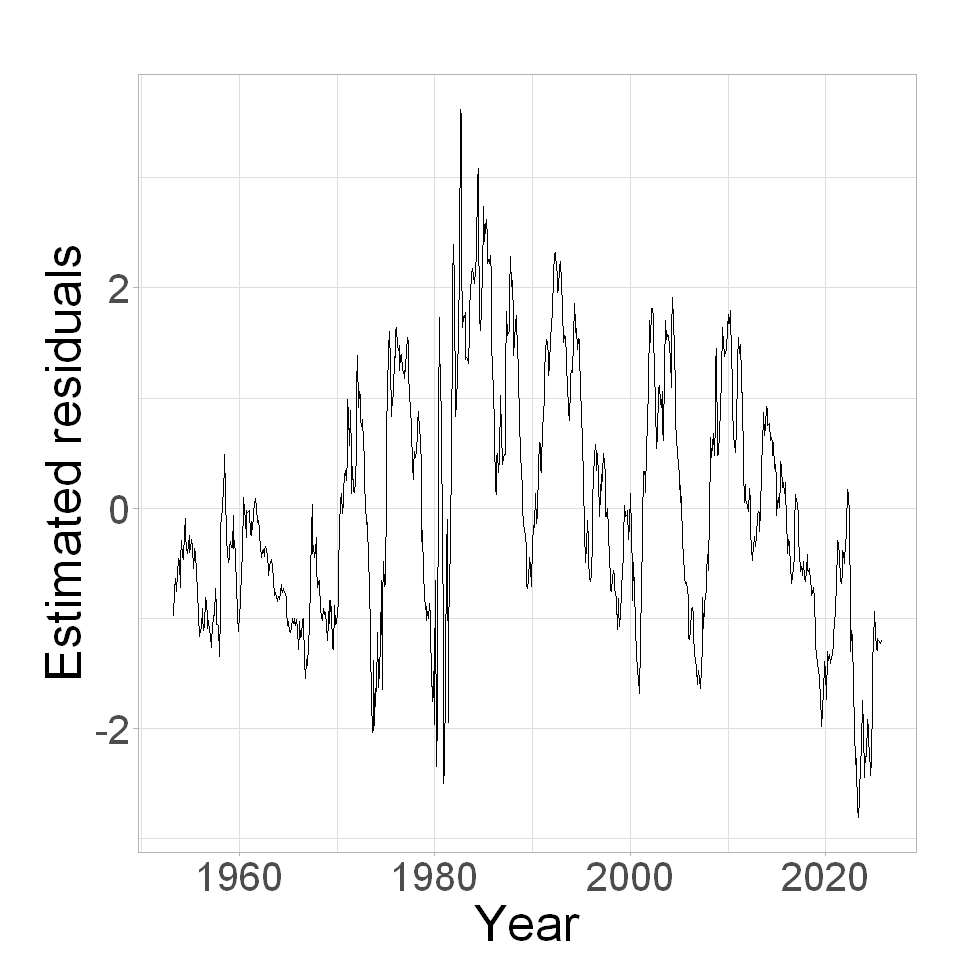

In [62]:
library(ggfortify)
options(repr.plot.width=8, repr.plot.height=8)
fig = autoplot(z1a, colour = 'black')
fig = fig + theme(aspect.ratio=1) +
theme_light() +
theme(aspect.ratio=1) +
theme(plot.margin = ggplot2::margin(0.2, 0.2, 0.2, 0.2, "cm")) +
theme(text=element_text(size=30)) +
labs(x = "Year") +
labs(y = "Estimated residuals")
fig

In [65]:
library(urca)
summary(ur.df(z1a, type='trend', lags=8, selectlags=c("AIC")))


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression trend 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + tt + z.diff.lag)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.81029 -0.12953 -0.00542  0.13351  2.10122 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  5.980e-03  1.897e-02   0.315 0.752651    
z.lag.1     -3.623e-02  8.915e-03  -4.064 5.28e-05 ***
tt          -1.402e-05  3.761e-05  -0.373 0.709346    
z.diff.lag1  3.157e-01  3.418e-02   9.237  < 2e-16 ***
z.diff.lag2 -2.088e-01  3.581e-02  -5.832 7.78e-09 ***
z.diff.lag3  1.392e-01  3.642e-02   3.822 0.000142 ***
z.diff.lag4 -7.869e-02  3.670e-02  -2.144 0.032320 *  
z.diff.lag5 -1.521e-03  3.660e-02  -0.042 0.966856    
z.diff.lag6 -3.877e-02  3.642e-02  -1.064 0.287427    
z.diff.lag7 -1.378e-02  3.545e-02  -0.389 0.697551    
z.diff.lag8  9.442e-02  3.413e-02   2.766 0

<div style="background-color:lightyellow; padding:15px; border-radius:5px;">

<h3>Interpreting the Engle–Granger Cointegration Test (with Trend)</h3>  
<h3>Long-term rate as a function of the short-term rate</h3>    
<br>


From the critical value table:
<ul>
  <li>φ₂ (5%) ≈ 4.68</li>
  <li>φ₃ (5%) ≈ 6.25</li>
</ul>

Since <b>φ₂ = 5.56 > 4.68</b> and <b>φ₃ = 8.33 > 6.25</b>,  
both are significant → you <b>retain the trend specification</b>.
<br><br>

Now, interpret <b>τ₃ = -4.0638</b> using the “with trend” critical values.
<br><br>

<h4>Calculating the Correct Critical Values for τ₃</h4>

The response surface formula from MacKinnon (2010) is:
<br><br>

\begin{align*}
\beta_\infty + \frac{\beta_1}{T} + \frac{\beta_2}{T^2}
\end{align*}
<br>

For <b>k = 2 (with trend)</b>:
<table style="width:80%; border-collapse:collapse; text-align:center;">
  <thead>
    <tr style="background-color:#fff3cd;">
      <th style="border:1px solid #ccc; padding:6px;">Level</th>
      <th style="border:1px solid #ccc; padding:6px;">β∞</th>
      <th style="border:1px solid #ccc; padding:6px;">β₁</th>
      <th style="border:1px solid #ccc; padding:6px;">β₂</th>
      <th style="border:1px solid #ccc; padding:6px;">T</th>
      <th style="border:1px solid #ccc; padding:6px;">Critical Value</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td style="border:1px solid #ccc; padding:6px;">1%</td>
      <td style="border:1px solid #ccc; padding:6px;">-4.3266</td>
      <td style="border:1px solid #ccc; padding:6px;">-15.531</td>
      <td style="border:1px solid #ccc; padding:6px;">-34.03</td>
      <td style="border:1px solid #ccc; padding:6px;">870</td>
      <td style="border:1px solid #ccc; padding:6px;">-4.3445</td>
    </tr>
    <tr>
      <td style="border:1px solid #ccc; padding:6px;">5%</td>
      <td style="border:1px solid #ccc; padding:6px;">-3.7809</td>
      <td style="border:1px solid #ccc; padding:6px;">-9.421</td>
      <td style="border:1px solid #ccc; padding:6px;">-15.06</td>
      <td style="border:1px solid #ccc; padding:6px;">870</td>
      <td style="border:1px solid #ccc; padding:6px;">-3.7917</td>
    </tr>
    <tr>
      <td style="border:1px solid #ccc; padding:6px;">10%</td>
      <td style="border:1px solid #ccc; padding:6px;">-3.4959</td>
      <td style="border:1px solid #ccc; padding:6px;">-7.203</td>
      <td style="border:1px solid #ccc; padding:6px;">-4.01</td>
      <td style="border:1px solid #ccc; padding:6px;">870</td>
      <td style="border:1px solid #ccc; padding:6px;">-3.5042</td>
    </tr>
  </tbody>
</table>

<br>

<h4>Decision</h4>

Compare your statistic, <b>τ = -4.0638,</b> with critical values: 
<ul>
  <li>-4.0638 &lt; -3.7917 → reject <i>H₀</i> at <b>5%</b></li>
  <li>-4.0638 &gt; -4.3445 → fail to reject <i>H₀</i> at <b>1%</b></li>
</ul>

<b>Conclusion:</b>  
There is <b>cointegration at the 5% level</b> (but not at 1%) between  long- and short-term interest rates.
<br><br>
</div>



In [63]:
# Load stargazer to print a regression table
library(stargazer)

# Align long- and short-rate series on common monthly dates
data1 = ts.intersect(ltir, stir)

# Estimate OLS: Short-term rate as a function of the long-term rate
model = lm(stir ~ ltir, data = data1)

# Print a plain-text regression summary
stargazer(model, type = "text")

# Extract OLS residuals
z1b = model$residuals

# Convert residuals to a monthly time-series object (starts Apr 1953)
z1b = ts(as.numeric(z1b), frequency = 12, start = c(1953, 4))


                        Dependent variable:    
                    ---------------------------
                               stir            
-----------------------------------------------
ltir                         0.975***          
                              (0.014)          
                                               
Constant                     -1.224***         
                              (0.088)          
                                               
-----------------------------------------------
Observations                    870            
R2                             0.845           
Adjusted R2                    0.845           
Residual Std. Error      1.204 (df = 868)      
F Statistic         4,732.675*** (df = 1; 868) 
Note:               *p<0.1; **p<0.05; ***p<0.01


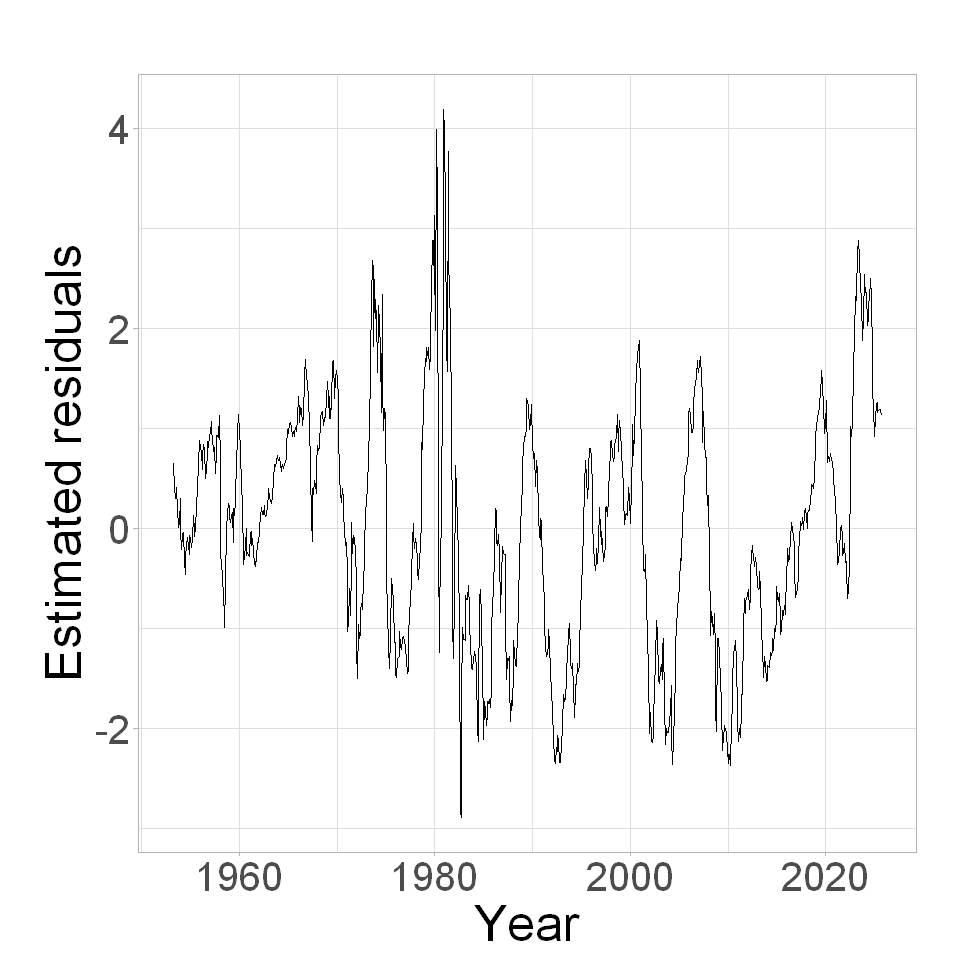

In [64]:
library(ggfortify)
options(repr.plot.width=8, repr.plot.height=8)
fig = autoplot(z1b, colour = 'black')
fig = fig + theme(aspect.ratio=1) +
theme_light() +
theme(aspect.ratio=1) +
theme(plot.margin = ggplot2::margin(0.2, 0.2, 0.2, 0.2, "cm")) +
theme(text=element_text(size=30)) +
labs(x = "Year") +
labs(y = "Estimated residuals")
fig

In [66]:
library(urca)
summary(ur.df(z1b, type='trend', lags=8, selectlags=c("AIC")))


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression trend 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + tt + z.diff.lag)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.57792 -0.13361  0.00311  0.13652  2.16358 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  7.490e-03  2.141e-02   0.350 0.726481    
z.lag.1     -4.279e-02  9.637e-03  -4.441 1.01e-05 ***
tt          -1.580e-05  4.256e-05  -0.371 0.710487    
z.diff.lag1  3.357e-01  3.415e-02   9.831  < 2e-16 ***
z.diff.lag2 -1.969e-01  3.598e-02  -5.472 5.84e-08 ***
z.diff.lag3  1.340e-01  3.642e-02   3.679 0.000249 ***
z.diff.lag4 -7.065e-02  3.670e-02  -1.925 0.054542 .  
z.diff.lag5  1.882e-02  3.657e-02   0.514 0.607054    
z.diff.lag6 -6.051e-02  3.645e-02  -1.660 0.097280 .  
z.diff.lag7 -1.586e-02  3.555e-02  -0.446 0.655627    
z.diff.lag8  1.054e-01  3.412e-02   3.089 0

<div style="background-color:lightyellow; padding:15px; border-radius:5px;">

<h3>Interpreting the Engle–Granger Cointegration Test (with Trend)</h3>  
<h3>Short-term rate as a function of the long-term rate</h3> 


From the critical value table:
<ul>
  <li>φ₂ (5%) ≈ 4.68</li>
  <li>φ₃ (5%) ≈ 6.25</li>
</ul>

Since <b>φ₂ = 6.60 > 4.68</b> and <b>φ₃ = 9.90 > 6.25</b>,  
both are significant → you <b>retain the trend specification</b>.
<br><br>

Now, interpret <b>τ₃ = -4.4407</b> using the “with trend” critical values.
<br><br>

<h4>Calculating the Correct Critical Values for τ₃</h4>

The response surface formula from MacKinnon (2010) is:
<br><br>

\begin{align*}
\beta_\infty + \frac{\beta_1}{T} + \frac{\beta_2}{T^2}
\end{align*}
<br>

For <b>k = 2 (with trend)</b>:
<br>
<table style="width:80%; border-collapse:collapse; text-align:center;">
  <thead>
    <tr style="background-color:#fff3cd;">
      <th style="border:1px solid #ccc; padding:6px;">Level</th>
      <th style="border:1px solid #ccc; padding:6px;">β∞</th>
      <th style="border:1px solid #ccc; padding:6px;">β₁</th>
      <th style="border:1px solid #ccc; padding:6px;">β₂</th>
      <th style="border:1px solid #ccc; padding:6px;">T</th>
      <th style="border:1px solid #ccc; padding:6px;">Critical Value</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td style="border:1px solid #ccc; padding:6px;">1%</td>
      <td style="border:1px solid #ccc; padding:6px;">-4.3266</td>
      <td style="border:1px solid #ccc; padding:6px;">-15.531</td>
      <td style="border:1px solid #ccc; padding:6px;">-34.03</td>
      <td style="border:1px solid #ccc; padding:6px;">870</td>
      <td style="border:1px solid #ccc; padding:6px;">-4.3445</td>
    </tr>
    <tr>
      <td style="border:1px solid #ccc; padding:6px;">5%</td>
      <td style="border:1px solid #ccc; padding:6px;">-3.7809</td>
      <td style="border:1px solid #ccc; padding:6px;">-9.421</td>
      <td style="border:1px solid #ccc; padding:6px;">-15.06</td>
      <td style="border:1px solid #ccc; padding:6px;">870</td>
      <td style="border:1px solid #ccc; padding:6px;">-3.7917</td>
    </tr>
    <tr>
      <td style="border:1px solid #ccc; padding:6px;">10%</td>
      <td style="border:1px solid #ccc; padding:6px;">-3.4959</td>
      <td style="border:1px solid #ccc; padding:6px;">-7.203</td>
      <td style="border:1px solid #ccc; padding:6px;">-4.01</td>
      <td style="border:1px solid #ccc; padding:6px;">870</td>
      <td style="border:1px solid #ccc; padding:6px;">-3.5042</td>
    </tr>
  </tbody>
</table>

<br>

<h4>Decision</h4>

Compare your statistic, <b>τ = -4.4407,</b> with critical values: 
<ul>
  <li>-4.4407 &lt; -3.7917 → reject <i>H₀</i> at <b>1%</b></li>
</ul>

<b>Conclusion:</b>  
There is <b>cointegration at the 1% level</b> between  long- and short-term interest rates.
<br><br>
</div>



<div style="background-color:lightyellow; padding:15px; border-radius:5px;">

<h3>Concluding Engle–Granger Cointegration Tests</h3>

<p>
We conducted two Engle–Granger tests to examine whether a long-term relationship exists between short-term and long-term interest rates.  
</p>

<p>
In the first test, we regressed <b>long-term interest rates</b> on <b>short-term interest rates</b> and then tested the residuals for stationarity. In the second test, we reversed the order — regressing <b>short-term interest rates</b> on <b>long-term interest rates</b> — and repeated the cointegration test.
</p>

<p>
In one case, we found evidence of a cointegrating relationship at the <b>5% significance level</b> (but not at 1%), while in the other case, we found cointegration significant even at the <b>1% level</b>.  
</p>

<p>
This difference highlights the <b>sensitivity of the Engle–Granger test</b> to the <b>choice of dependent and independent variables</b> in the initial regression. Because the test is based on residuals from a single-equation estimation, reversing the regression direction can lead to different residual dynamics, and hence, different conclusions about cointegration.  
</p>

<p>
In practice, this asymmetry is one of the main drawbacks of the Engle–Granger approach. More robust methods, such as the <b>Johansen cointegration test</b>, treat all variables as potentially endogenous and provide a system-based framework that is invariant to the choice of normalization.
</p>

</div>


<div style="background-color:#e6f2ff; padding:15px; border-radius:5px;">

<h2>Phillips–Ouliaris Residual-based Test for Cointegration</h2>  

Another well-known residual-based test for cointegration is the <b>Phillips–Ouliaris (1990)</b> test.  
It builds upon the Engle–Granger approach but improves it in several important ways.  
While both methods rely on testing whether the residuals from a cointegrating regression are stationary, the Phillips–Ouliaris test corrects some of the limitations of the Engle–Granger procedure.


In the Engle–Granger test, the result may depend on which variable is treated as the dependent variable in the first-stage regression.  
For instance, estimating  


\begin{align*}
Y_t = \alpha + \theta X_t + Z_t
\end{align*}

and testing the residuals may yield different conclusions than estimating  


\begin{align*}
X_t = \alpha' + \theta' Y_t + Z'_t.
\end{align*}
<br><br>

This dependence arises because the OLS regression assumes a particular <b>normalization</b> of the cointegrating relationship — that is, it depends on which variable is placed on the left-hand side.

<br>
The Phillips–Ouliaris test addresses this issue by constructing test statistics that are <b>invariant to the normalization</b> of the cointegrating relationship.  
In other words, the choice of dependent variable no longer affects the inference about cointegration.  
This makes the test more robust and theoretically appealing, especially in systems where the variables play symmetric roles.

<br>
Like the Engle–Granger method, the Phillips–Ouliaris test examines whether the residuals from the cointegrating regression are stationary.  
However, it uses a different estimation and testing framework based on the asymptotic distribution of the residuals and their long-run covariance structure.  
This approach provides more accurate critical values and avoids potential bias introduced by the OLS normalization.
<br><br>

<b>Hypotheses of the Phillips–Ouliaris Cointegration Test:</b>  


$H_0$:  No cointegration between the variables (the residuals are non-stationary)
    
$H_1$:  Cointegration exists (the residuals are stationary) 

    
<br>

If the null hypothesis is rejected, we conclude that the variables share a stable <b>long-run equilibrium relationship</b> despite being individually non-stationary.

</div>


In [27]:
# Phillips--Ouliaris Cointegration Test
library(urca)
# summary(ca.po(data, demean = c("none", "constant", "trend"),
#      lag = c("short", "long"), type = c("Pu", "Pz"), tol = NULL))
# lag = "long" — series exhibit strong autocorrelation
# lag = "short" — series exhibit weak autocorrelation
summary(ca.po(data1, lag = "long", demean = "trend", type = "Pz"))


######################################## 
# Phillips and Ouliaris Unit Root Test # 
######################################## 

Test of type Pz 
detrending of series with constant and linear trend 

Response ltir :

Call:
lm(formula = ltir ~ zr + trd)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.71205 -0.12676 -0.00879  0.12939  1.58404 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  7.171e-02  2.925e-02   2.452   0.0144 *  
zrltir       9.768e-01  7.838e-03 124.613   <2e-16 ***
zrstir       1.817e-02  7.448e-03   2.440   0.0149 *  
trd         -4.004e-05  3.719e-05  -1.077   0.2819    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.2619 on 865 degrees of freedom
Multiple R-squared:  0.9918,	Adjusted R-squared:  0.9917 
F-statistic: 3.473e+04 on 3 and 865 DF,  p-value: < 2.2e-16


Response stir :

Call:
lm(formula = stir ~ zr + trd)

Residuals:
    Min      1Q  Median      3Q     Max 
-4

<div style="background-color:lightyellow; padding:15px; border-radius:5px;">

<h3>Interpreting the Phillips–Ouliaris Cointegration Test (with Trend)</h3>  

<ul style="line-height:1.6;">
  <li>The <b>test statistic (75.09)</b> lies <b>between the 10% and 5% critical values</b>.</li>
  <li>This means we <b>reject the null hypothesis of no cointegration at the 10% significance level</b>,  
  but <b>cannot reject it at the 5% level</b>.</li>
</ul>

</div>


<div style="background-color:#e6f2ff; padding:15px; border-radius:5px;">

<h2> Exercise 2</h2>
    Test for cointegration between income and cosumption per capita.
</div>    

<div style="background-color:#e6f2ff; padding:15px; border-radius:5px;">

<h2> Solution to Exercise 2</h2>
</div> 

In [67]:
# Load stargazer to print a regression table
library(stargazer)

# Align long- and short-rate series on common monthly dates
data2 = ts.intersect(inc, con)

# Estimate OLS: Income as a function of consumption
model = lm(inc ~ con, data = data2)

# Print a plain-text regression summary
stargazer(model, type = "text")

# Extract OLS residuals
z2a = model$residuals

# Convert residuals to a monthly time-series object (starts Q1 1959)
z2a = ts(as.numeric(z2), frequency = 4, start = c(1959, 1))


                        Dependent variable:    
                    ---------------------------
                                inc            
-----------------------------------------------
con                          1.079***          
                              (0.007)          
                                               
Constant                   1,611.624***        
                             (196.821)         
                                               
-----------------------------------------------
Observations                    266            
R2                             0.990           
Adjusted R2                    0.989           
Residual Std. Error    1,149.927 (df = 264)    
F Statistic         24,921.320*** (df = 1; 264)
Note:               *p<0.1; **p<0.05; ***p<0.01


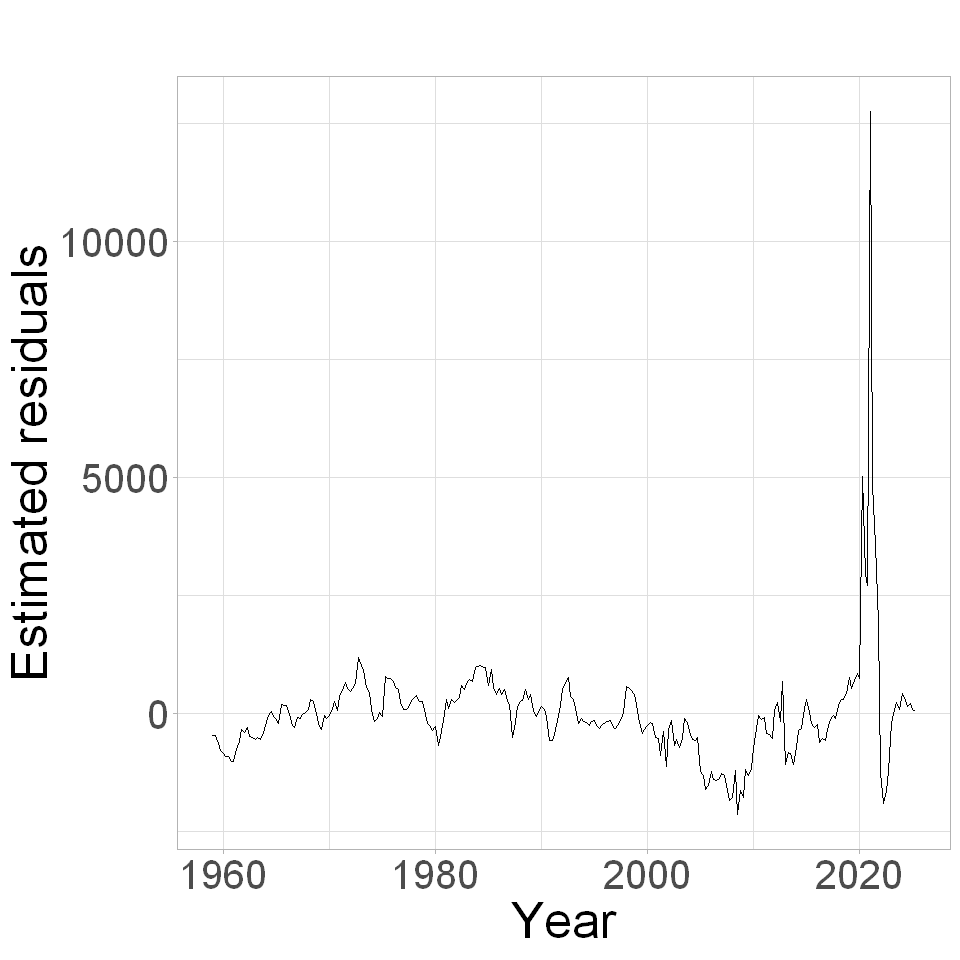

In [68]:
library(ggfortify)
options(repr.plot.width=8, repr.plot.height=8)
fig = autoplot(z2a, colour = 'black')
fig = fig + theme(aspect.ratio=1) +
theme_light() +
theme(aspect.ratio=1) +
theme(plot.margin = ggplot2::margin(0.2, 0.2, 0.2, 0.2, "cm")) +
theme(text=element_text(size=30)) +
labs(x = "Year") +
labs(y = "Estimated residuals")
fig

In [69]:
library(urca)
summary(ur.df(z2a, type='trend', lags=8, selectlags=c("AIC")))


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression trend 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + tt + z.diff.lag)

Residuals:
    Min      1Q  Median      3Q     Max 
-3979.9  -167.2   -14.5   161.2  9260.9 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  18.17636  101.14687   0.180 0.857533    
z.lag.1      -0.22958    0.05849  -3.925 0.000112 ***
tt           -0.05482    0.64936  -0.084 0.932786    
z.diff.lag1  -0.23231    0.07205  -3.224 0.001433 ** 
z.diff.lag2   0.01253    0.06925   0.181 0.856593    
z.diff.lag3   0.32797    0.06627   4.949 1.38e-06 ***
z.diff.lag4  -0.09140    0.06915  -1.322 0.187469    
z.diff.lag5  -0.16631    0.06808  -2.443 0.015263 *  
z.diff.lag6  -0.16860    0.06248  -2.698 0.007445 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 771.7 on 248 degrees of f

<div style="background-color:lightyellow; padding:15px; border-radius:5px;">

<h3>Interpreting the Engle–Granger Cointegration Test (with Trend)</h3>  
<h3> Income as a function of consumption</h3>
<br>

From your critical-value table:
<ul>
  <li>φ₂ (5%) = <b>4.71</b></li>
  <li>φ₃ (5%) = <b>6.30</b></li>
</ul>

Your test statistics are:  
<b>τ₃ = −3.9255</b>, <b>φ₂ = 5.1638</b>, <b>φ₃ = 7.7309</b>.
<br><br>

Since <b>φ₂ = 5.1638 > 4.71</b> and <b>φ₃ = 7.7309 > 6.30</b>,  
both are significant at 5% → we <b>retain the trend specification</b>.
<br><br>

<h4>Calculating the Correct Critical Values for τ₃</h4>

The response surface formula from MacKinnon (2010) is:
<br><br>

\begin{align*}
\beta_\infty + \frac{\beta_1}{T} + \frac{\beta_2}{T^2}
\end{align*}
<br>

For <b>k = 2 (with trend)</b>:

<table style="width:80%; border-collapse:collapse; text-align:center;">
  <thead>
    <tr style="background-color:#fff3cd;">
      <th style="border:1px solid #ccc; padding:6px;">Level</th>
      <th style="border:1px solid #ccc; padding:6px;">β∞</th>
      <th style="border:1px solid #ccc; padding:6px;">β₁</th>
      <th style="border:1px solid #ccc; padding:6px;">β₂</th>
      <th style="border:1px solid #ccc; padding:6px;">T</th>
      <th style="border:1px solid #ccc; padding:6px;">Critical Value</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td style="border:1px solid #ccc; padding:6px;">1%</td>
      <td style="border:1px solid #ccc; padding:6px;">-4.3266</td>
      <td style="border:1px solid #ccc; padding:6px;">-15.531</td>
      <td style="border:1px solid #ccc; padding:6px;">-34.03</td>
      <td style="border:1px solid #ccc; padding:6px;">266</td>
      <td style="border:1px solid #ccc; padding:6px;">-4.3855</td>
    </tr>
    <tr>
      <td style="border:1px solid #ccc; padding:6px;">5%</td>
      <td style="border:1px solid #ccc; padding:6px;">-3.7809</td>
      <td style="border:1px solid #ccc; padding:6px;">-9.421</td>
      <td style="border:1px solid #ccc; padding:6px;">-15.06</td>
      <td style="border:1px solid #ccc; padding:6px;">266</td>
      <td style="border:1px solid #ccc; padding:6px;">-3.8165</td>
    </tr>
    <tr>
      <td style="border:1px solid #ccc; padding:6px;">10%</td>
      <td style="border:1px solid #ccc; padding:6px;">-3.4959</td>
      <td style="border:1px solid #ccc; padding:6px;">-7.203</td>
      <td style="border:1px solid #ccc; padding:6px;">-4.01</td>
      <td style="border:1px solid #ccc; padding:6px;">266</td>
      <td style="border:1px solid #ccc; padding:6px;">-3.5230</td>
    </tr>
  </tbody>
</table>


<br>

<h4>Decision</h4>

Compare test statistic, <b>τ = -3.9255,</b> with critical values:  
<ul>
  <li>-3.9255 &lt; -3.8165 → reject <i>H₀</i> at <b>5%</b></li>
  <li>-3.9255 &gt; -4.3855 → fail to reject <i>H₀</i> at <b>1%</b></li>
</ul>

<b>Conclusion:</b>  
There is <b>cointegration at the 5% level</b> (but not at 1%) between income and consumption per capita.
<br><br>
</div>


In [70]:
# Load stargazer to print a regression table
library(stargazer)

# Align long- and short-rate series on common monthly dates
data2 = ts.intersect(inc, con)

# Estimate OLS: consumption as a function of income
model = lm(con ~ inc, data = data2)

# Print a plain-text regression summary
stargazer(model, type = "text")

# Extract OLS residuals
z2b = model$residuals

# Convert residuals to a monthly time-series object (starts Q1 1959)
z2b = ts(as.numeric(z2b), frequency = 4, start = c(1959, 1))


                        Dependent variable:    
                    ---------------------------
                                con            
-----------------------------------------------
inc                          0.917***          
                              (0.006)          
                                               
Constant                   -1,195.980***       
                             (189.359)         
                                               
-----------------------------------------------
Observations                    266            
R2                             0.990           
Adjusted R2                    0.989           
Residual Std. Error    1,059.980 (df = 264)    
F Statistic         24,921.320*** (df = 1; 264)
Note:               *p<0.1; **p<0.05; ***p<0.01


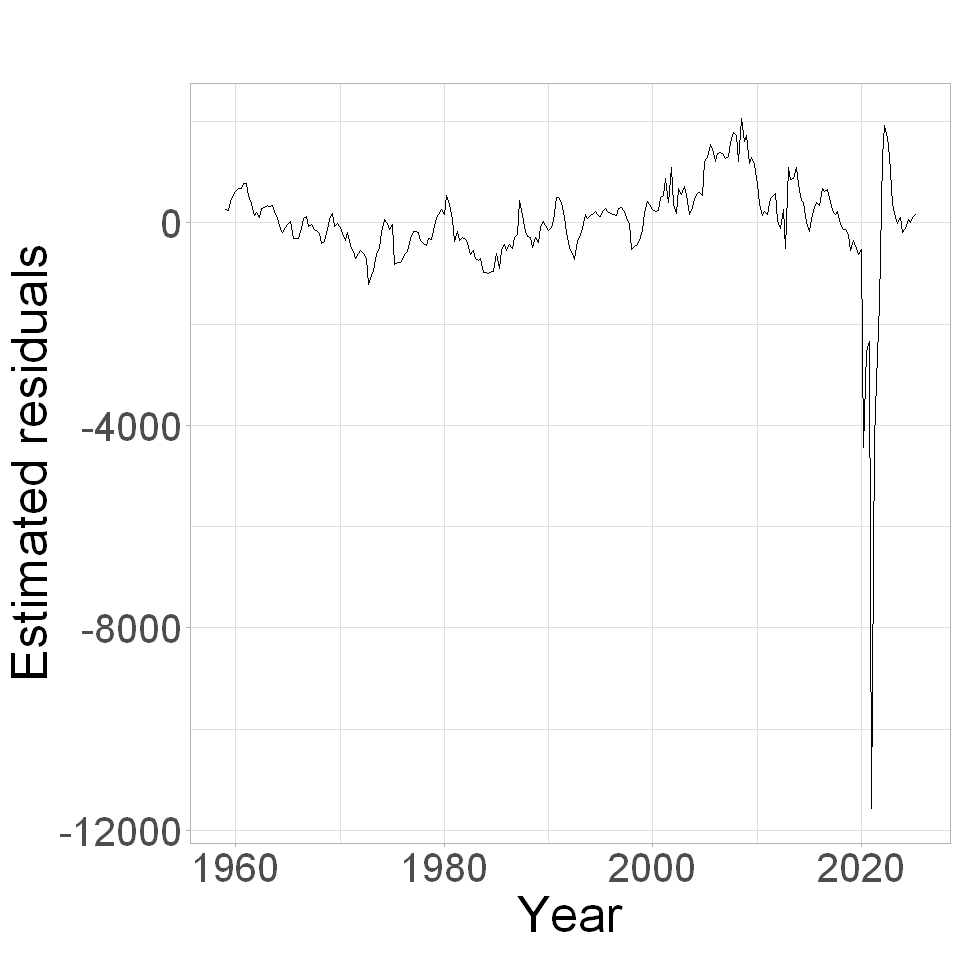

In [71]:
library(ggfortify)
options(repr.plot.width=8, repr.plot.height=8)
fig = autoplot(z2b, colour = 'black')
fig = fig + theme(aspect.ratio=1) +
theme_light() +
theme(aspect.ratio=1) +
theme(plot.margin = ggplot2::margin(0.2, 0.2, 0.2, 0.2, "cm")) +
theme(text=element_text(size=30)) +
labs(x = "Year") +
labs(y = "Estimated residuals")
fig

In [35]:
library(urca)
summary(ur.df(z2b, type='trend', lags=8, selectlags=c("AIC")))


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression trend 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + tt + z.diff.lag)

Residuals:
    Min      1Q  Median      3Q     Max 
-3979.9  -167.2   -14.5   161.2  9260.9 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  18.17636  101.14687   0.180 0.857533    
z.lag.1      -0.22958    0.05849  -3.925 0.000112 ***
tt           -0.05482    0.64936  -0.084 0.932786    
z.diff.lag1  -0.23231    0.07205  -3.224 0.001433 ** 
z.diff.lag2   0.01253    0.06925   0.181 0.856593    
z.diff.lag3   0.32797    0.06627   4.949 1.38e-06 ***
z.diff.lag4  -0.09140    0.06915  -1.322 0.187469    
z.diff.lag5  -0.16631    0.06808  -2.443 0.015263 *  
z.diff.lag6  -0.16860    0.06248  -2.698 0.007445 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 771.7 on 248 degrees of f

<div style="background-color:#e6f2ff; padding:15px; border-radius:5px;">


<h2>Symmetry in Cointegration Testing for Consumption and Income</h2>

<p>
Unlike in the case of short- and long-term interest rates, here the unit root test statistics for the residuals are <b>the same</b> regardless of whether we regress <b>consumption on income</b> or <b>income on consumption</b>.  
</p>

<p>
This symmetry arises because the variables are <b>almost perfectly correlated</b>, with an <b>R-squared value close to 1 (0.990)</b>. When the R-squared is this high, the residuals from both regression directions are nearly identical, leading to identical or very similar results in the Engle–Granger cointegration test.  
</p>

<p>
In other words, when two series move almost one-for-one over time, the choice of which variable is treated as dependent in the initial regression becomes practically irrelevant. This contrasts with cases like short- and long-term interest rates, where the correlation is lower, and the test results are more sensitive to the choice of normalization.  
</p>

<p>
This example illustrates that the <b>Engle–Granger test’s asymmetry</b> is less of a concern when the two series are highly collinear, as both regression residuals capture essentially the same stationary component of their long-run equilibrium relations


In [31]:
# Phillips--Ouliaris Cointegration Test
library(urca)
# summary(ca.po(data, demean = c("none", "constant", "trend"),
#      lag = c("short", "long"), type = c("Pu", "Pz"), tol = NULL))
# lag = "long" — series exhibit strong autocorrelation
# lag = "short" — series exhibit weak autocorrelation
summary(ca.po(data2, lag = "long", demean = "trend", type = "Pz"))


######################################## 
# Phillips and Ouliaris Unit Root Test # 
######################################## 

Test of type Pz 
detrending of series with constant and linear trend 

Response inc :

Call:
lm(formula = inc ~ zr + trd)

Residuals:
    Min      1Q  Median      3Q     Max 
-2047.9  -155.1    -4.4   141.4  6421.7 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 789.59536  342.69327   2.304    0.022 *  
zrinc         0.79545    0.03489  22.797  < 2e-16 ***
zrcon         0.17838    0.03885   4.591 6.85e-06 ***
trd           6.20378    4.56720   1.358    0.176    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 592.1 on 261 degrees of freedom
Multiple R-squared:  0.9972,	Adjusted R-squared:  0.9972 
F-statistic: 3.128e+04 on 3 and 261 DF,  p-value: < 2.2e-16


Response con :

Call:
lm(formula = con ~ zr + trd)

Residuals:
    Min      1Q  Median      3Q     Max 
-4162.4   -74.8    21.

<div style="background-color:lightyellow; padding:15px; border-radius:5px;">

<h3>Interpreting the Phillips–Ouliaris Cointegration Test (with Trend)</h3>  

<ul style="line-height:1.6;">
  <li>The <b>test statistic (140.77)</b> lies <b>in the rejection region</b>.</li>
  <li>This means we <b>reject the null hypothesis of no cointegration at any conventional significance level</b>.</li>
</ul>

</div>

<div style="background-color:#e6f2ff; padding:15px; border-radius:5px;">

  <h2>Error Correction Model (ECM)</h2>

  <p>
    If two variables are cointegrated, it means they follow the same stochastic trend — in other words, they exhibit the same long-run co-movements.
    Hence, it is natural to exploit this long-term (equilibrium) relationship when modeling the data.
    Cointegration ensures that while the individual series may be non-stationary, there exists a 
    <b>long-term, stable relationship</b> that holds.
    The ECM models this by allowing short-term deviations from equilibrium while ensuring that the variables adjust over time to maintain the long-run relationship.
  </p>

  <h3>Granger Representation Theorem</h3>

  <p>
    If two series $\{Y_t\}$ and $\{X_t\}$ are cointegrated, then their relationship can be expressed as an 
    <b>Error Correction Model (ECM)</b>:
  </p>

  $$ 
  \begin{aligned}
  \Delta Y_t &= \gamma_{10} + \alpha_1(Y_{t-1}-\theta X_{t-1}) + \gamma_{11}\Delta Y_{t-1} + \gamma_{12}\Delta X_{t-1} + \varepsilon_{1t} \\
  \Delta X_t &= \gamma_{20} + \underbrace{\alpha_2(Y_{t-1}-\theta X_{t-1})}_{\text{long-run equilibrium}} 
  + \underbrace{\gamma_{21}\Delta Y_{t-1} + \gamma_{22}\Delta X_{t-1}}_{\text{short-run movements}} + \varepsilon_{2t}
  \end{aligned}
  $$

  <p>
    The ECM captures both the <b>short-run dynamics</b> and the <b>long-run equilibrium adjustment</b> between the series.
  </p>

  <h3>Expansion of Key Concepts</h3>

  <h4>1) Cointegration and Long-Run Equilibrium</h4>

  <blockquote>
    The ECM is applicable because the two series $\{Y_t\}$ and $\{X_t\}$ are cointegrated.  
    This means that while both may individually exhibit non-stationary behavior, there exists a stable, long-term relationship between them, captured by the term $(Y_{t-1} - \theta X_{t-1})$, which represents deviations from equilibrium.  
    <br><br>
    The coefficient $\theta$ reflects the equilibrium relationship between $Y_t$ and $X_t$. Over time, deviations from this equilibrium should correct themselves — this adjustment process is modeled by the ECM.
  </blockquote>

  <h4>2) Short-Run and Long-Run Dynamics</h4>

  <blockquote>
    The ECM separates the <b>long-run equilibrium</b> from the <b>short-run dynamics</b>:  
    <br><br>
    • <b>Long-run equilibrium:</b> Captured by the term $\alpha_1 (Y_{t-1} - \theta X_{t-1})$.  
    It represents how quickly deviations from equilibrium are corrected.  
    The coefficient $\alpha_1$ indicates the <b>speed of adjustment</b> — a larger absolute value means faster correction, while a smaller one means slower adjustment.  
    <br><br>
    • <b>Short-run movements:</b> Captured by the lagged differences $\Delta Y_{t-1}$ and $\Delta X_{t-1}$, which describe the immediate responses of $Y_t$ and $X_t$ to short-term changes.
  </blockquote>

  <h4>3) Adjustment Mechanism</h4>

  <blockquote>
    If $\alpha_1 = 0$, then $Y_t$ does not adjust to correct for deviations from the long-run equilibrium — all adjustment must come from $X_t$.  
    In this case, $Y_t$ is said to be <b>weakly exogenous</b>.  
    <br><br>
    If $\alpha_1 \neq 0$, then $Y_t$ participates in restoring equilibrium, meaning both variables contribute to the correction mechanism.
  </blockquote>

  <h4>4) Weak Exogeneity and Granger Causality</h4>

  <blockquote>
    The concept of <b>weak exogeneity</b> is crucial in cointegrated systems.  
    If $X_t$ is weakly exogenous, it does not respond to deviations from equilibrium, so all adjustment occurs through $Y_t$.  
    <br><br>
    In such cases, <b>Granger causality</b> must be interpreted carefully:  
    $Y_t$ does not Granger-cause $X_t$ if lagged values of $Y_t$ do not appear in the $X_t$ equation and do not influence its return to equilibrium.
  </blockquote>

</div>


In [75]:
# Load VAR/VECM tools
library(vars)

# Pick lag length using information criteria (AIC, HQ, SC, FPE)
VARselect(ts.intersect(ltir, stir), lag.max = 10, type = "const")$selection

# Load VECM estimation functions
library(tsDyn)

# Estimate a VECM on the (level) data:
#   lag = 2  -> corresponding VAR order for levels minus, so 3-1 = 2
#   r   = 1  -> cointegration rank 1
#   include = "const" -> constant (typically in the cointegration space)
#   estim = "ML" -> Johansen ML estimation
vecm_model = VECM(ts.intersect(ltir, stir), lag = 2, r = 1, include = "const", estim = "ML")

# Show output
summary(vecm_model)

AIC(n)  HQ(n)  SC(n) FPE(n) 
    10     10      3     10

#############
###Model VECM 
#############
Full sample size: 870 	End sample size: 867
Number of variables: 2 	Number of estimated slope parameters 12
AIC -4512.293 	BIC -4450.348 	SSR 162.9608
Cointegrating vector (estimated by ML):
   ltir      stir
r1    1 -1.033294


              ECT                Intercept          ltir -1          
Equation ltir -0.0160(0.0069)*   0.0206(0.0118).    0.3885(0.0394)***
Equation stir 0.0257(0.0102)*    -0.0299(0.0175).   0.3054(0.0582)***
              stir -1             ltir -2            stir -2           
Equation ltir -0.0228(0.0268)     -0.2561(0.0399)*** 0.0519(0.0268).   
Equation stir 0.3169(0.0396)***   -0.1760(0.0589)**  -0.1066(0.0395)** 

<div style="background-color:lightyellow; padding:15px; border-radius:5px;">

  <h2>Interpretation of the ECM Output</h2>

  <blockquote>
    Based on the output of the Error Correction Model (ECM), both the short-term interest rate (STIR) and the long-term interest rate (LTIR) adjust toward restoring the long-run equilibrium — but in opposite directions.
  </blockquote>

 

  <h3><b>1. Error Correction Term (ECT)</b></h3>

  <blockquote>
    The coefficients on the Error Correction Term (ECT) show how much each variable adjusts when the system deviates from its long-run equilibrium:
  </blockquote>

  <blockquote>
    <b>LTIR equation</b> (ECT coefficient: -0.0160):  
    When the long-term interest rate (LTIR) is <b>above its long-run equilibrium value</b> $(Y_{t-1} - \theta X_{t-1} > 0)$, the error correction term (ECT) is <b>positive</b>.  
    The <b>negative coefficient</b> (-0.0160) means LTIR will <b>decrease</b> in the next period to move back toward equilibrium.  
    This adjustment ensures LTIR moves in the direction that restores the long-run balance with STIR.
  </blockquote>

  <blockquote>
    <b>STIR equation</b> (ECT coefficient: 0.0257):  
    When LTIR is <b>above its long-run equilibrium value</b> $(Y_{t-1} - \theta X_{t-1} > 0)$, the error correction term is <b>positive</b>.  
    The <b>positive coefficient</b> (0.0257) implies that STIR will <b>increase</b> in the next period to help close the gap.  
    Thus, STIR adjusts in the opposite direction to LTIR, reinforcing the correction toward the long-run equilibrium.
  </blockquote>

  <blockquote>
    <b>Summary of adjustments:</b>
  </blockquote>

  <table style="width:100%; border-collapse:collapse; text-align:center;">
    <tr style="background-color:#cce6ff;">
      <th>Situation</th>
      <th>ECT sign</th>
      <th>LTIR coefficient (-0.0160)</th>
      <th>STIR coefficient (+0.0257)</th>
      <th>Adjustment Direction</th>
    </tr>
    <tr>
      <td>LTIR above equilibrium</td>
      <td>$$ECT > 0$$</td>
      <td>LTIR ↓</td>
      <td>STIR ↑</td>
      <td>Both move toward equilibrium</td>
    </tr>
    <tr style="background-color:#f2f9ff;">
      <td>LTIR below equilibrium</td>
      <td>$$ECT < 0$$</td>
      <td>LTIR ↑</td>
      <td>STIR ↓</td>
      <td>Both move toward equilibrium</td>
    </tr>
  </table>



  <h3><b>2. Speed of Adjustment</b></h3>

  <blockquote>
    The magnitude of the ECT coefficients reflects how quickly each variable responds to deviations from the long-run equilibrium:
  </blockquote>

  <blockquote>
    • For LTIR, the adjustment speed is <b>0.0154 percentage points per period</b>, indicating a relatively gradual correction.  
    • For STIR, the adjustment speed is <b>0.0252 percentage points per period</b>, suggesting a slightly faster correction toward equilibrium.
  </blockquote>

  

  <h3><b>3. Granger Causality</b></h3>

  <blockquote>
    Granger causality is assessed through both the significance of the ECT and the lagged terms of each variable:
  </blockquote>

  <ul>
    <li><b>Error Correction Term (ECT):</b>  
      The significance of the ECT in both equations indicates that both STIR and LTIR respond to deviations from the long-run relationship.  
      This implies a <b>bidirectional long-run causality</b> between the two interest rates.
    </li>
    <br>
    <li><b>Lagged Terms:</b>  
      The presence of significant lagged variables further supports short-run interactions:
      <blockquote>
        • Significant lagged <b>STIR</b> terms in the LTIR equation suggest that past short-term rates influence the long-term rate.  
        • Significant lagged <b>LTIR</b> terms in the STIR equation suggest that past long-term rates influence the short-term rate.
      </blockquote>
    </li>
  </ul>

  

  <h3><b>4. Conclusion</b></h3>

  <blockquote>
    Both STIR and LTIR adjust toward the long-run equilibrium, but in opposite directions:  
    • <b>LTIR decreases</b> when the equilibrium is above its current level.  
    • <b>STIR increases</b> when the equilibrium is below its current level.  
    <br><br>
    The statistically significant ECT coefficients (denoted by * and **) confirm that both interest rates actively contribute to restoring equilibrium.  
    The speeds of adjustment are <b>0.0154</b> and <b>0.0252</b> percentage points per period for LTIR and STIR, respectively.
  </blockquote>

</div>



<div style="background-color:lightyellow; padding:15px; border-radius:5px;">

<h2>Interpreting the Error-Correction Term in a VECM</h2>

<p>
When estimating a VECM, the <b>order of variables</b> in the input determines how the <b>cointegrating relationship</b> is normalized. Specifically, the first variable in the dataset is given a coefficient of 1 in the estimated cointegration vector.
</p>

<p>
For example:
</p>

<ul>
<li>If we specify <code>vecm_model = VECM(ts.intersect(stir, ltir), lag = 2, r = 1, include = "const", estim = "ML")</code>, the cointegrating relationship is expressed such that <b>short-term interest rate (stir)</b> has a coefficient of 1.</li>
<li>If we specify <code>vecm_model = VECM(ts.intersect(ltir, stir), lag = 2, r = 1, include = "const", estim = "ML")</code>, the relationship is normalized on the <b>long-term interest rate (ltir)</b> instead, giving it a coefficient of 1.</li>
</ul>

<p>
This normalization affects how we interpret the <b>Error-Correction Term (ECT)</b>:
</p>

<ul>
<li>When <b>ltir</b> has a coefficient of 1, a <b>positive ECT</b> indicates that the <b>long-term interest rate exceeds its long-run equilibrium value</b>, prompting adjustment in subsequent periods.</li>
<li>When <b>stir</b> has a coefficient of 1, a <b>positive ECT</b> means that the <b>short-term interest rate is above its long-run equilibrium level</b>.</li>
</ul>

<p>
Thus, while the cointegrating relationship itself represents the same equilibrium linkage between the two rates, the <b>interpretation of deviations from equilibrium (ECT)</b> depends on which variable the model normalizes to have a coefficient of 1.
</p>

</div>


<div style="background-color:#e6f2ff; padding:15px; border-radius:5px;">

<h2> Exercise 3</h2>
    
Estimate Error Correction Model for income and cosumption per capita.
</div>    

<div style="background-color:#e6f2ff; padding:15px; border-radius:5px;">

<h2> Solution to Exercise 3</h2>

</div> 

In [79]:
# Load VAR/VECM tools
library(vars)

# Pick lag length using information criteria (AIC, HQ, SC, FPE)
VARselect(ts.intersect(log(inc), log(con)), lag.max = 10, type = "const")$selection

# Load VECM estimation functions
library(tsDyn)

# Estimate a VECM on the (level) data:
#   lag = 3  -> corresponding VAR order for levels minus, so 4-1 = 3
#   r   = 1  -> cointegration rank 1
#   include = "const" -> constant (typically in the cointegration space)
#   estim = "ML" -> Johansen ML estimation
vecm_model = VECM(ts.intersect(log(inc), log(con)), lag = 3, r = 1, include = "const", estim = "ML")

# Show output
summary(vecm_model)

AIC(n)  HQ(n)  SC(n) FPE(n) 
     4      4      4      4

#############
###Model VECM 
#############
Full sample size: 266 	End sample size: 262
Number of variables: 2 	Number of estimated slope parameters 16
AIC -4772.831 	BIC -4712.169 	SSR 0.05918396
Cointegrating vector (estimated by ML):
   log(inc)   log(con)
r1        1 -0.9516216


                  ECT                Intercept          log(inc) -1       
Equation log(inc) -0.1013(0.0313)**  0.0669(0.0194)***  -0.1558(0.0683)*  
Equation log(con) 0.1369(0.0225)***  -0.0818(0.0140)*** 0.1305(0.0493)**  
                  log(con) -1         log(inc) -2         log(con) -2        
Equation log(inc) -0.0116(0.0848)     0.0139(0.0690)      -0.1330(0.0844)    
Equation log(con) 0.1094(0.0611).     -0.0115(0.0497)     0.1693(0.0608)**   
                  log(inc) -3        log(con) -3       
Equation log(inc) 0.4390(0.0666)***  0.2368(0.0817)**  
Equation log(con) -0.2130(0.0480)*** 0.0183(0.0589)    

<div style="background-color:lightyellow; padding:15px; border-radius:5px;">

  <h2>Interpretation of the ECM Output (Income and Consumption per Capita)</h2>


  <h3><b>1. Error Correction Terms (ECT)</b></h3>

  <blockquote>
    The ECT coefficients show how income and consumption adjust when the system deviates from its long-run equilibrium:
  </blockquote>

  <blockquote>
    • <b>Income equation (ECT = -0.1013**):</b>  
    When income is above its long-run equilibrium level, the positive deviation $(Y_{t-1}-\theta X_{t-1} > 0)$ 
    triggers a <b>negative adjustment</b> in income growth.  
    The coefficient -0.1013 means about <b>10.1% of the disequilibrium</b> is corrected each period.  
    Income therefore moves back toward the long-run equilibrium.
    <br><br>
    • <b>Consumption equation (ECT = 0.1369***):</b>  
    When income is above equilibrium, the positive ECT leads to a <b>positive adjustment</b> in consumption growth.  
    The 0.1369 coefficient implies consumption increases by about <b>13.7% of the disequilibrium</b> per period.  
    Thus, consumption adjusts in the <b>opposite direction</b> of income, helping restore equilibrium.
  </blockquote>

  <blockquote>
    <b>Summary of adjustments:</b>
  </blockquote>

  <table style="width:100%; border-collapse:collapse; text-align:center;">
    <tr style="background-color:#cce6ff;">
      <th>Situation</th>
      <th>ECT sign</th>
      <th>Income coefficient (-0.1013)</th>
      <th>Consumption coefficient (+0.1369)</th>
      <th>Adjustment Direction</th>
    </tr>
    <tr>
      <td>Income above equilibrium</td>
      <td>$$ECT > 0$$</td>
      <td>Income ↓</td>
      <td>Consumption ↑</td>
      <td>Both restore equilibrium</td>
    </tr>
    <tr style="background-color:#f2f9ff;">
      <td>Income below equilibrium</td>
      <td>$$ECT < 0$$</td>
      <td>Income ↑</td>
      <td>Consumption ↓</td>
      <td>Both restore equilibrium</td>
    </tr>
  </table>

  

  <h3><b>2. Speed of Adjustment</b></h3>

  <blockquote>
    The absolute value of the ECT coefficients shows the <b>speed of convergence</b> toward the long-run equilibrium:  
    • Income adjusts at about <b>10.1%</b> per period.  
    • Consumption adjusts at about <b>13.7%</b> per period.  
    These magnitudes suggest a fairly balanced and stable adjustment process.
  </blockquote>

  

  <h3><b>3. Granger Causality</b></h3>

  <blockquote>
    • The significance of the ECTs in both equations implies <b>bidirectional long-run causality</b> between income and consumption.  
    • The significance of lagged Δinc and Δcon terms suggests <b>short-run feedback effects</b>:  
      income shocks influence consumption in subsequent periods, and vice versa.
  </blockquote>


  <h3><b>5. Conclusion</b></h3>

  <blockquote>
    Income and consumption per capita are cointegrated, confirming a <b>stable long-run relationship</b> between them.  
    Deviations from equilibrium are corrected gradually through opposite short-run adjustments in income and consumption.  
    Both series are responsive — income slightly more so — and their dynamic interplay maintains long-run economic balance.
  </blockquote>

</div>


<div style="background-color:lightyellow; padding:15px; border-radius:5px;">

<h2>Interpreting the Error-Correction Term as the Speed of Gap Closure</h2>

<p>
If you want to interpret the <b>Error-Correction Term (ECT)</b> as showing how much of the <b>long-run gap</b> between two variables closes each period, then, it’s standard practice to work with the <b>logarithms</b> of the variables, especially when they represent quantities such as consumption and income that grow over time and are measured in levels.
</p>

<p>
By taking logs (for example, using <code>ts.intersect(log(con), log(inc))</code>), you transform the variables so that their differences represent <b>approximate percentage changes</b> rather than absolute level differences. In this case, the cointegrating relationship captures a <b>long-run proportional equilibrium</b> between consumption and income, such as:
</p>

<p style="text-align:center;">
log(Consumption) = α + β · log(Income) + u<sub>t</sub>
</p>

<p>
The residual <code>u<sub>t</sub></code> (the ECT) then measures the <b>percentage deviation</b> from this long-run equilibrium — that is, how far consumption and income are from their steady-state relationship.
</p>

<p>
In the VECM, the coefficient on the lagged ECT (say, −0.3) represents the <b>speed of adjustment</b> — how much of that deviation is corrected each period. For example, an adjustment coefficient of −0.3 means that <b>30% of the gap closes</b> in each period.
</p>

<p>
So, using logs not only stabilizes the variance and makes the series more interpretable but also allows you to interpret the ECT coefficient as the <b>rate of proportional convergence</b> back to the long-run equilibrium.
</p>

</div>


%%shell

jupyter nbconvert --to html ///content/lecture_7.ipynb